<a href="https://colab.research.google.com/github/hmao401/Weather-Forecasting-with-LSTM-GRU-and-ARIMA/blob/main/GHCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Miniproject: Modelling the climate or the weather?

Is past performance an indicator of future weather?

## Global Historial Climatology Network
GHCN (Global Historical Climatology Network)-Daily is an integrated database of daily climate summaries from land surface stations across the globe.

THe GHCN has many datasets from weather stations across the globe. A [README describing the data form is available here](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/readme.txt). The [stations.txt](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt) file and [countries.txt](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt) contain information about the stations and countries.


### Machine Learning Tasks:
1. Can you design a machine learning technique that can predict the climate (defined as the weekly or monthly average) a year in advance?  [Later in the term files containing the 2021 data will be made available
2. Can you design a machine learning technique that can predict the weather (temperature, rainfall, snow fall, etc.) any better than assuming that the weather tomorrow will be exactly the same as the weather today

### Potential extensions
1. Can you train a machine learning technique to predict 10 or 20 years into the future?
2. Where will the hotest part of the world be in 20 years time?
3. What else can you study with this dataset? Is the sun in Utah a predictor of the rain in Spain?
4. How close do weather stations need to be to provide reliable forecasts at other stations?

### Caveats
This is real data from weather stations around the world. This means that there are 'holes' in the data. You must be able to handle these 'holes' in some error tolerant fashion.


### Task Overview

In this task, we are working with **climate data** from the **Global Historical Climatology Network Data (GHNCD)**, focusing on station-level temperature and precipitation data. Our goal is to explore and analyze the historical weather data of various stations around the world, particularly focusing on the **TMAX (maximum temperature)**, **TMIN (minimum temperature)**, and **PRCP (precipitation)** variables.

To achieve this, we:
1. **Examine the GHNCD data files** using custom functions to extract relevant climate variables.
2. **Create a structured representation** of each weather station, including its coordinates, elevation, and the historical data for TMAX, TMIN, and PRCP.
3. **Visualize the climate data** for the selected stations, identifying patterns and trends in temperature and precipitation over time.
4. **Perform statistical analysis** (e.g., correlation analysis) to understand how climate variables interact across different stations and how they evolve over time.

This analysis will provide insight into climate trends, helping to identify regions with significant temperature or precipitation shifts, which can be valuable for further research or climate modeling tasks.


### Pre-processing

In [36]:
# Import all necessary packages
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBRegressor
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Lambda, Input
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix, accuracy_score
from statsmodels.tsa.seasonal import seasonal_decompose
from geopy.distance import geodesic
from scipy.optimize import curve_fit
from math import radians, cos, sin, sqrt, atan2
import itertools
import datetime

In [37]:
# Class representing a weather station with relevant attributes
class Station():
    def __init__(self, sid, lat, lon, el, state, name, gsn, hcn, wmo, country):
        self.sid = sid          # Station ID
        self.lat = lat          # Latitude
        self.lon = lon          # Longitude
        self.el = el            # Elevation
        self.state = state      # State or region
        self.name = name        # Station name
        self.gsn = gsn          # Global Surface Network (GSN) indicator
        self.hcn = hcn          # Historical Climatology Network (HCN) indicator
        self.wmo = wmo          # WMO station code
        self.country = country  # Country code

    def __str__(self):
        # Return a formatted string of station info
        return self.sid + " is " + self.name + ", " + self.country + " at " + str(self.lat) + ", " + str(self.lon) + ", " + str(self.el)

# Class to manage the Global Historical Climatology Network Data (GHNCD)
class GHNCD:
    def __init__(self):
        # Column lengths for station data fields
        self.station_col_len = [11, 4, 2, 4]
        for _ in range(31):
            self.station_col_len.extend([5, 3])

    def chunkstring(self, string, lengths):
        # Split a string into chunks based on the given lengths
        return (string[pos:pos+length].strip()
                for idx, length in enumerate(lengths)
                for pos in [sum(map(int, lengths[:idx]))])

    def processFile(self, fileName):
        # Process the .dly file and return data in dictionary format
        outDict = {}
        with open(fileName, 'r') as fp:
            line = fp.readline()
            while line:
                # Split data into fields based on column lengths
                fields = list(self.chunkstring(line, self.station_col_len))
                station = fields[0]
                year = int(fields[1])
                month = int(fields[2])
                field = fields[3]
                vals = fields[4::2]
                flags = fields[5::2]

                # Helper function to handle missing data (flag = '')
                def checkInt(x, flag):
                    if flag == '':
                        return -9999
                    return int(x)

                ivals = [checkInt(x, flag) for x, flag in zip(vals, flags)]
                monthDict = dict(year=year, month=month, field=field, vals=ivals, flags=flags)

                # Store the data in the output dictionary, keyed by variable field
                if field in outDict:
                    outDict[field]['monthList'].append(monthDict)
                else:
                    outDict[field] = dict(monthList=[monthDict])
                line = fp.readline()
        return outDict

    def readCountriesFile(self, fileName=None):
        # Read country codes and names from a file
        self.countryDict = {}
        if fileName is None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt')
        else:
            file = open(fileName, 'r')

        # Read country codes and their corresponding names
        for line in file:
            c = line[0:2].strip()
            d = line[3:].strip()
            self.countryDict[c] = d
        print("Read", len(self.countryDict), "countries and codes")

    def readStationsFile(self, fileName=None, justGSN=True):
        # Read station data from a file and populate station dictionary
        self.stationDict = {}
        if fileName is None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt')
        else:
            file = open(fileName, 'r')

        # Read and process station data
        for line in file:
            sid = line[0:11].strip()  # Station ID
            lat = float(line[12:20].strip())  # Latitude
            lon = float(line[21:30].strip())  # Longitude
            el = float(line[31:37].strip())  # Elevation
            state = line[38:40].strip()  # State
            name = line[41:71].strip()  # Station name
            gsn = line[72:75].strip()  # GSN code
            hcn = line[76:79].strip()  # HCN code
            wmo = line[80:85].strip()  # WMO code

            # Skip stations without GSN if 'justGSN' flag is set
            if justGSN and gsn == '':
                continue

            # Get country name from countryDict
            country_code = sid[:2]
            country = self.countryDict.get(country_code, "Unknown")
            self.stationDict[sid] = Station(sid, lat, lon, el, state, name, gsn, hcn, wmo, country)

        print("Read", len(self.stationDict), "stations with justGSN", justGSN)

    def getVar(self, statDict, varName='TMAX'):
        # Retrieve variable data (e.g., TMAX, TMIN, PRCP)
        cal = 0.1 if varName not in ['SNOW', 'SNWD'] else 1.0
        tempList = [
            (datetime.date(month['year'], month['month'], ind+1), cal * val)
            for month in statDict.get(varName, {}).get('monthList', [])
            for ind, val in enumerate(month['vals'])
            if val != -9999
        ]
        return tempList

    def getTMAX(self, statDict):
        # Wrapper for getVar() to fetch TMAX specifically
        return self.getVar(statDict, 'TMAX')

    def printStation(self, sid):
        # Print station details for a given station ID
        print(self.stationDict[sid])

    def getStation(self, sid):
        # Return the Station object for a given station ID
        return self.stationDict[sid]

    def getStatKeyNames(self):
        # Return a list of station IDs
        return list(self.stationDict.keys())


In [38]:
# Find station files
ghn = GHNCD()

# Download the countries file if it doesn't exist
countries_file = "ghcnd-countries.txt"
if not os.path.exists(countries_file):
    url = 'http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt'
    urllib.request.urlretrieve(url, countries_file)

ghn.readCountriesFile(countries_file)

# Download the stations file if it doesn't exist
stations_file = "ghcnd-stations.txt"
if not os.path.exists(stations_file):
    url = 'http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt'
    urllib.request.urlretrieve(url, stations_file)

ghn.readStationsFile(stations_file, justGSN=True)

base_dir = "ghcnd_gsn"  # Folder where files are unpacked

Read 219 countries and codes
Read 991 stations with justGSN True


In [39]:
# Get list of station names
statNames=ghn.getStatKeyNames()

# Arbitrary number from 0 to 990
whichStat=220
fileName=statNames[whichStat]+'.dly'
urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

# Copy a network object to a local file
urllib.request.urlretrieve(urlName,fileName)
statDict=ghn.processFile(fileName)
print(ghn.getStation(statNames[whichStat]))


CA002400404 is ARCTIC BAY CS, Canada at 73.0, -85.0167, 10.0


5341


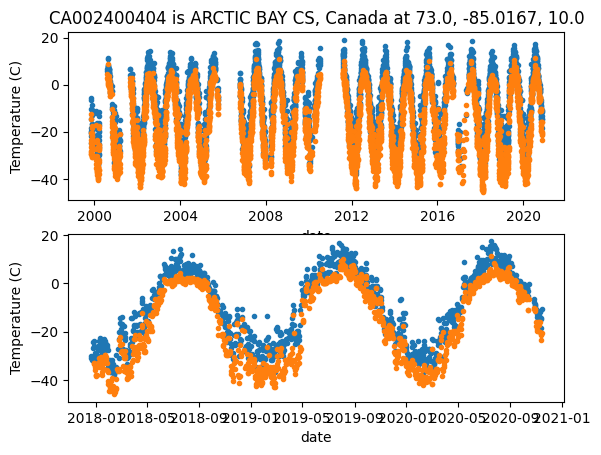

In [40]:
# Retrieve temperature data for TMAX (Max Temp) and TMIN (Min Temp)
tmaxArray = ghn.getVar(statDict, 'TMAX')
days, tmax = zip(*tmaxArray)

tminArray = ghn.getVar(statDict, 'TMIN')
days2, tmin = zip(*tminArray)

# Print the number of available data points
print(len(days))

# Create plots for TMAX and TMIN over time
fig, ax = plt.subplots(2, 1)
ax[0].plot(days, tmax, '.')
ax[0].plot(days2, tmin, '.')
ax[0].set_xlabel("date")
ax[0].set_ylabel("Temperature (C)")
ax[0].set_title(ghn.getStation(statNames[whichStat]))

# Plot the last 1000 days of data
ax[1].plot(days[-1000:], tmax[-1000:], '.')
ax[1].plot(days2[-1000:], tmin[-1000:], '.')
ax[1].set_xlabel("date")
ax[1].set_ylabel("Temperature (C)")

# Retrieve and unzip precipitation and snowfall data
prcpArray = ghn.getVar(statDict, 'PRCP')
snowArray = ghn.getVar(statDict, 'SNOW')
days_prcp, prcp = zip(*prcpArray)
days_snow, snow = zip(*snowArray)


## Cleaning the data

### Cleaning/filtering

Before performing any analysis on the climate data, it is crucial to ensure that the dataset is **clean** and **well-structured**. Raw climate data can contain **missing values**, **outliers**, or **invalid entries**, which can distort the results of the analysis.

In this section, we will:
1. **Remove or handle missing values** (e.g., entries with -9999, which indicate missing or erroneous data).
2. **Filter out irrelevant data**: If certain variables or stations are not required for the analysis, we will discard them to reduce noise and focus on the most relevant data.
3. **Ensure proper formatting**: Ensure all data is in the correct format (e.g., dates are in `datetime` format, numerical values are appropriately scaled).

By performing these cleaning and filtering steps, we can ensure that the subsequent analysis and modeling will be based on **accurate** and **reliable** data.

In [41]:
# Check length consistency before merging
print(len(days), len(tmax), len(tmin))

# Create DataFrames for TMAX and TMIN
df_tmax = pd.DataFrame({'date': days, 'TMAX': tmax})
df_tmin = pd.DataFrame({'date': days2, 'TMIN': tmin})

# Convert 'date' column to datetime format
df_tmax["date"] = pd.to_datetime(df_tmax["date"], errors="coerce")
df_tmin["date"] = pd.to_datetime(df_tmin["date"], errors="coerce")

# Merge TMAX and TMIN dataframes on date
df_weather = pd.merge(df_tmax, df_tmin, on="date", how="outer")

5341 5341 5428


In [42]:
# Replace invalid (-9999) values with NaN
df_weather.replace(-9999, np.nan, inplace=True)

# Convert 'date' column to datetime
df_weather['date'] = pd.to_datetime(df_weather['date'], errors="coerce")

# Ensure 'date' is set as the index for merging
df_weather.set_index('date', inplace=True)

# Create DataFrames for PRCP and SNOW
df_prcp = pd.DataFrame({'date': pd.to_datetime(days_prcp, errors="coerce"), 'PRCP': prcp}).set_index('date')
df_snow = pd.DataFrame({'date': pd.to_datetime(days_snow, errors="coerce"), 'SNOW': snow}).set_index('date')

# Merge precipitation data
df_weather = df_weather.merge(df_prcp, left_index=True, right_index=True, how='outer')

# Merge snowfall data, handling potential column name conflicts
df_weather = df_weather.merge(df_snow, left_index=True, right_index=True, how='outer', suffixes=('', '_snow'))

# If 'SNOW_snow' column was created during merge, combine it with 'SNOW' and drop it
if 'SNOW_snow' in df_weather.columns:
    df_weather['SNOW'] = df_weather['SNOW'].combine_first(df_weather['SNOW_snow'])
    df_weather.drop(columns=['SNOW_snow'], inplace=True)

# Reset index after merging
df_weather.reset_index(inplace=True)

In [43]:
# Replace invalid (-9999) values with NaN
df_weather.replace(-9999, np.nan, inplace=True)

# Create DataFrames for PRCP and SNOW
df_prcp = pd.DataFrame({'date': pd.to_datetime(days_prcp, errors="coerce"), 'PRCP': prcp})
df_snow = pd.DataFrame({'date': pd.to_datetime(days_snow, errors="coerce"), 'SNOW': snow})

# Merge precipitation data
df_weather = df_weather.merge(df_prcp, on='date', how='outer')

# Merge snowfall data and restore missing values
df_weather = df_weather.merge(df_snow, on='date', how='outer', suffixes=('', '_snow'))
df_weather['SNOW'] = df_weather['SNOW'].combine_first(df_weather['SNOW_snow'])
df_weather.drop(columns=['SNOW_snow'], inplace=True)  # Cleanup redundant column

# Ensure date column is datetime format again after merging
df_weather['date'] = pd.to_datetime(df_weather['date'])


In [44]:
# Handle missing snowfall data properly
df_weather['SNOW'].fillna(df_snow['SNOW'], inplace=True)  # Use real snowfall data where possible
df_weather['SNOW'].fillna(0, inplace=True)  # Set remaining missing SNOW values to 0

# Apply forward-fill and backward-fill to other missing values
df_weather.fillna(method='ffill', inplace=True)
df_weather.fillna(method='bfill', inplace=True)

# Print sanity checks
print(df_weather.shape)  # Shape of the DataFrame
print(df_weather.head(10))  # First 10 rows
print(df_weather.tail(10))  # Last 10 rows
print(df_weather.isna().sum())  # Count remaining NaN values

(5566, 6)
        date  TMAX  TMIN  PRCP_x  SNOW  PRCP_y
0 1999-11-01 -18.6 -29.3     0.0   0.0     0.0
1 1999-11-02 -18.6 -29.3     0.0   0.0     0.0
2 1999-11-03 -18.6 -29.3     0.0   0.0     0.0
3 1999-11-04 -18.6 -29.3     0.0   0.0     0.0
4 1999-11-05 -18.6 -29.3     0.0   0.0     0.0
5 1999-11-06 -18.6 -29.3     0.0   0.0     0.0
6 1999-11-07 -20.5 -24.6     0.0   0.0     0.0
7 1999-11-08 -20.3 -26.4     0.0   0.0     0.0
8 1999-11-09 -24.8 -28.5     0.0   0.0     0.0
9 1999-11-10 -19.8 -28.0     0.0   0.0     0.0
           date  TMAX  TMIN  PRCP_x  SNOW  PRCP_y
5556 2020-11-05 -14.5 -17.2     0.1   0.0     0.1
5557 2020-11-06 -14.5 -19.5     0.4   0.0     0.4
5558 2020-11-07 -13.5 -17.4     1.7   0.0     1.7
5559 2020-11-08 -13.3 -16.0     0.0   0.0     0.0
5560 2020-11-09 -11.7 -16.0     0.1   0.0     0.1
5561 2020-11-10 -11.3 -20.3     0.2   0.0     0.2
5562 2020-11-11 -18.6 -23.5     0.0   0.0     0.0
5563 2020-11-12 -14.7 -20.9     0.8   0.0     0.8
5564 2020-11-13 -14.5 -

/tmp/ipython-input-313250435.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_weather['SNOW'].fillna(df_snow['SNOW'], inplace=True)  # Use real snowfall data where possible
/tmp/ipython-input-313250435.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doin

In [45]:
# Resolve duplicate PRCP columns after merging
if 'PRCP_x' in df_weather.columns and 'PRCP_y' in df_weather.columns:
    df_weather['PRCP'] = df_weather[['PRCP_x', 'PRCP_y']].max(axis=1)  # Take the max value if both exist
    df_weather.drop(columns=['PRCP_x', 'PRCP_y'], inplace=True)  # Remove redundant columns

# Ensure 'PRCP' column is present before applying transformations
if 'PRCP' not in df_weather.columns:
    raise KeyError("PRCP column is missing after merging. Check the data sources.")

# Log-transform precipitation to normalize distribution
df_weather["PRCP"] = np.log1p(df_weather["PRCP"])

# Extract month and day of the week for seasonality awareness
df_weather['Month'] = df_weather['date'].dt.month
df_weather['DayOfWeek'] = df_weather['date'].dt.dayofweek

# Add lag features safely
df_weather['TMAX_lag1'] = df_weather['TMAX'].shift(1)
df_weather['TMIN_lag1'] = df_weather['TMIN'].shift(1)
df_weather['PRCP_lag1'] = df_weather['PRCP'].shift(1) if 'PRCP' in df_weather.columns else np.nan
df_weather['SNOW_lag1'] = df_weather['SNOW'].shift(1) if 'SNOW' in df_weather.columns else np.nan



In [46]:
# Set date as the index for resampling
df_weather.set_index("date", inplace=True)

# Resample to weekly and monthly averages
df_weekly = df_weather.resample("W").mean()
df_monthly = df_weather.resample("M").mean()

# Fill any remaining missing values
df_monthly.ffill(inplace=True)
df_monthly.bfill(inplace=True)

# Double-check for missing values after resampling
print("Missing values after resampling:")
print(df_monthly.isna().sum())

Missing values after resampling:
TMAX         0
TMIN         0
SNOW         0
PRCP         0
Month        0
DayOfWeek    0
TMAX_lag1    0
TMIN_lag1    0
PRCP_lag1    0
SNOW_lag1    0
dtype: int64


/tmp/ipython-input-347141206.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_weather.resample("M").mean()


In [47]:
# Sanity check
print(df_weather.shape)  # (rows, columns)
print(df_weather.head(10))  # Show the first 10 rows
print(df_weather.tail(10))  # Show the last 10 rows
print(df_weather.isna().sum())

(5566, 10)
            TMAX  TMIN  SNOW  PRCP  Month  DayOfWeek  TMAX_lag1  TMIN_lag1  \
date                                                                         
1999-11-01 -18.6 -29.3   0.0   0.0     11          0        NaN        NaN   
1999-11-02 -18.6 -29.3   0.0   0.0     11          1      -18.6      -29.3   
1999-11-03 -18.6 -29.3   0.0   0.0     11          2      -18.6      -29.3   
1999-11-04 -18.6 -29.3   0.0   0.0     11          3      -18.6      -29.3   
1999-11-05 -18.6 -29.3   0.0   0.0     11          4      -18.6      -29.3   
1999-11-06 -18.6 -29.3   0.0   0.0     11          5      -18.6      -29.3   
1999-11-07 -20.5 -24.6   0.0   0.0     11          6      -18.6      -29.3   
1999-11-08 -20.3 -26.4   0.0   0.0     11          0      -20.5      -24.6   
1999-11-09 -24.8 -28.5   0.0   0.0     11          1      -20.3      -26.4   
1999-11-10 -19.8 -28.0   0.0   0.0     11          2      -24.8      -28.5   

            PRCP_lag1  SNOW_lag1  
date             

### Initial preprocessing

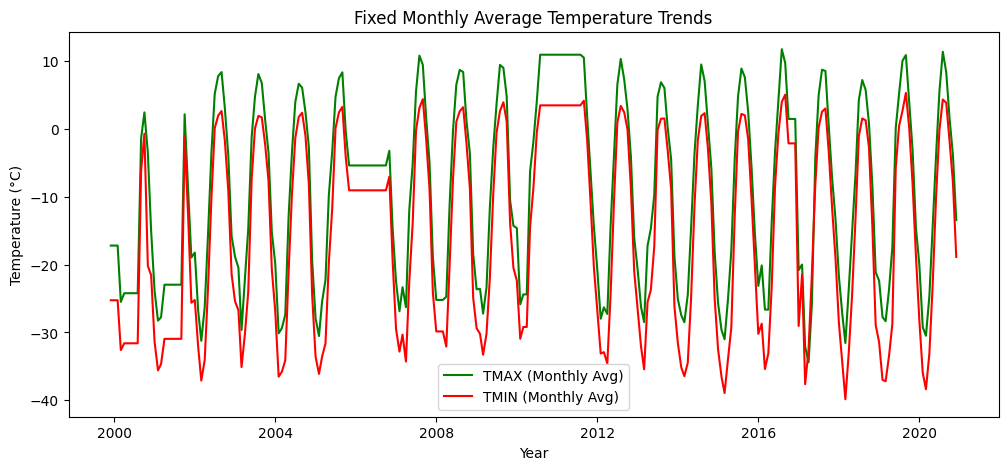

In [48]:
# Plots the monthly trends of average temperature (tmin and tmax)
plt.figure(figsize=(12, 5))
plt.plot(df_monthly.index, df_monthly["TMAX"], label="TMAX (Monthly Avg)", color="green")
plt.plot(df_monthly.index, df_monthly["TMIN"], label="TMIN (Monthly Avg)", color="red")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.title("Fixed Monthly Average Temperature Trends")
plt.legend()
plt.show()

Polynomial and spline interpolation methods were tried in order to fill missing values, but they either introduced instability, unrealistic oscillations, or failed due to date index constraints. As a result, forward-fill (ffill) and backward-fill (bfill) were chosen as the most reliable approach.


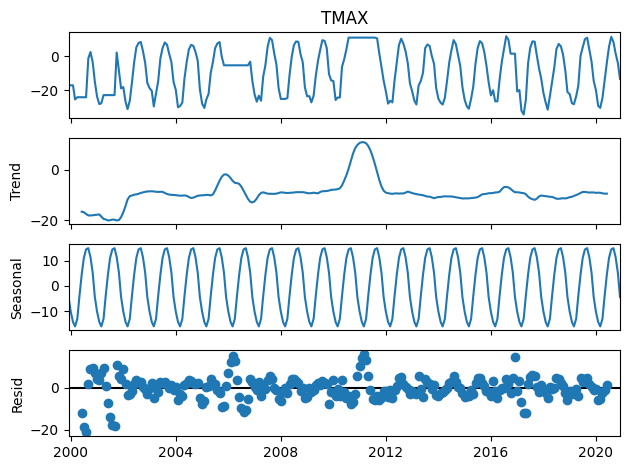


Summary Statistics:
              TMAX         TMIN         SNOW         PRCP        Month  \
count  5566.000000  5566.000000  5566.000000  5566.000000  5566.000000   
mean     -9.656522   -15.924524     0.240568     0.097863     6.659899   
std      14.116641    14.899149     3.078339     0.313664     3.455875   
min     -39.200000   -45.800000     0.000000     0.000000     1.000000   
25%     -22.300000   -29.800000     0.000000     0.000000     4.000000   
50%      -8.800000   -15.800000     0.000000     0.000000     7.000000   
75%       3.200000    -0.500000     0.000000     0.000000    10.000000   
max      19.100000    11.500000    80.000000     3.384390    12.000000   

         DayOfWeek    TMAX_lag1    TMIN_lag1    PRCP_lag1    SNOW_lag1  
count  5566.000000  5565.000000  5565.000000  5565.000000  5565.000000  
mean      3.006109    -9.656334   -15.923720     0.097775     0.240611  
std       1.996123    14.117902    14.900367     0.313624     3.078614  
min       0.000000  

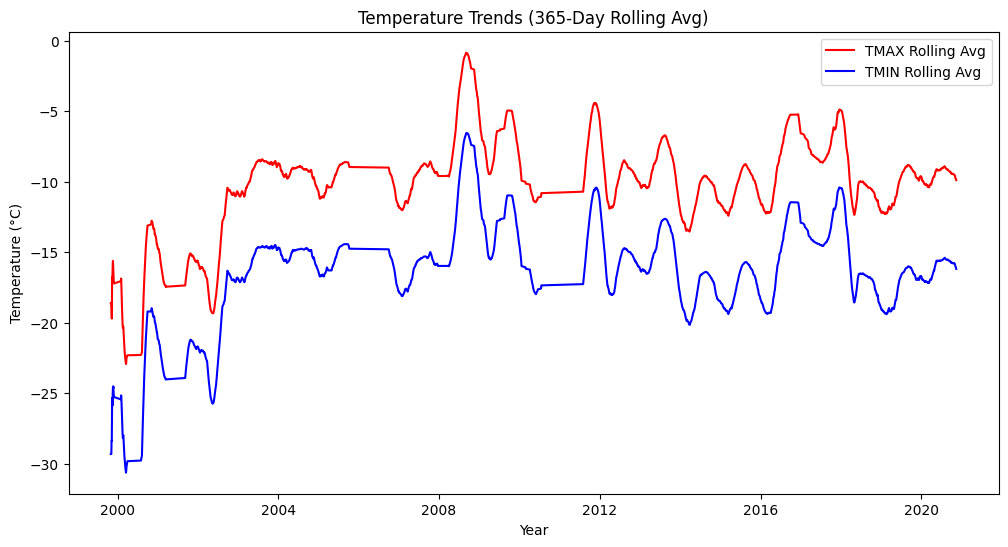

In [49]:
# Seasonal decomposition
decomposition = seasonal_decompose(df_monthly["TMAX"], model="additive", period=12)
decomposition.plot()
plt.show()

# Summary of statistics
print("\nSummary Statistics:")
print(df_weather.describe())

# Calculates rolling average trends
df_weather['TMAX_rolling'] = df_weather["TMAX"].rolling(window=365, min_periods=1).mean()
df_weather['TMIN_rolling'] = df_weather["TMIN"].rolling(window=365, min_periods=1).mean()

# Plots the rolling averages
plt.figure(figsize=(12, 6))
plt.plot(df_weather.index, df_weather['TMAX_rolling'], label='TMAX Rolling Avg', color='red')
plt.plot(df_weather.index, df_weather['TMIN_rolling'], label='TMIN Rolling Avg', color='blue')
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Trends (365-Day Rolling Avg)")
plt.legend()
plt.show()


The summary statistics provide insight into the dataset's temperature distribution:
- `count`: Number of data points available for TMAX and TMIN.
- `mean`: The average temperature over the dataset.
- `std`: Standard deviation, indicating variability in temperature.
- `min` and `max`: The lowest and highest recorded temperatures.
- `25%`, `50% (median)`, `75%`: Quartiles showing the spread of temperature values.

The `TMAX` (Maximum Temperature) and `TMIN` (Minimum Temperature) monthly averages demonstrate seasonal variations, with clear periodic fluctuations over time. The rolling average trend indicates long-term temperature shifts, highlighting periods of warming and cooling.
Seasonal decomposition shows distinct cyclical patterns in TMAX, confirming
the influence of yearly weather cycles.
The data also highlights extreme temperature events, which can be valuable for
identifying climate anomalies or trends in temperature variability over the years.

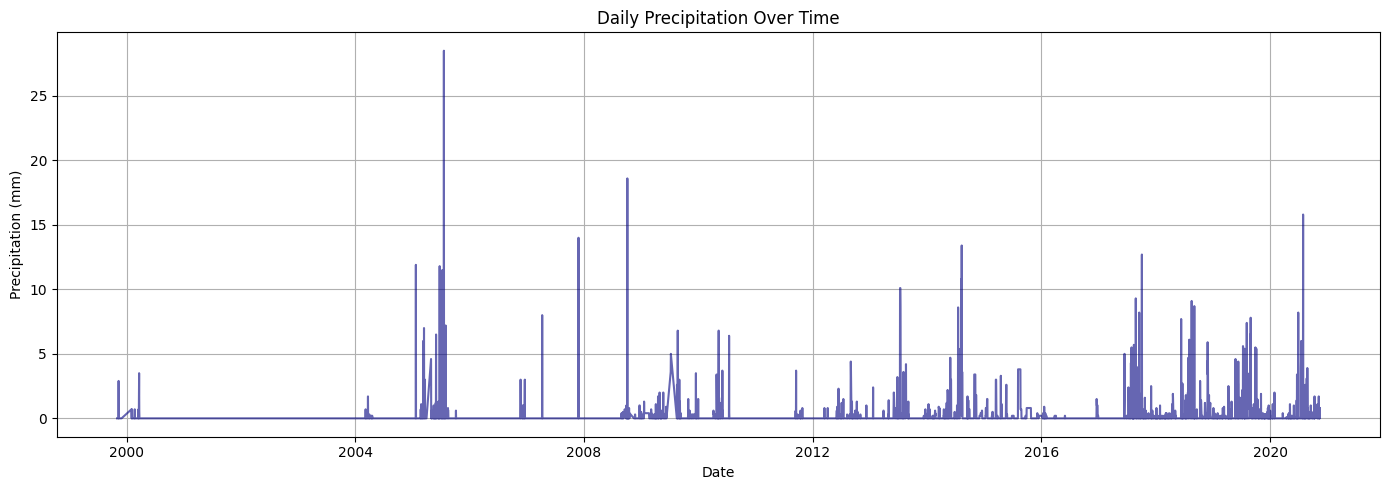

In [50]:
# Plots all precipitation data
plt.figure(figsize=(14, 5))
plt.plot(df_weather.index, np.expm1(df_weather['PRCP']), color='navy', alpha=0.6)
plt.title("Daily Precipitation Over Time")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.grid(True)
plt.tight_layout()
plt.show()


count     22.000000
mean      60.863636
std      127.881007
min        0.000000
25%        0.000000
50%        0.000000
75%       45.250000
max      426.000000
Name: SNOW, dtype: float64
Year
1999      0.0
2000     40.0
2001    420.0
2002    206.0
2003      0.0
2004     47.0
2005    426.0
2006    120.0
2007     80.0
2008      0.0
2009      0.0
2010      0.0
2011      0.0
2012      0.0
2013      0.0
2014      0.0
2015      0.0
2016      0.0
2017      0.0
2018      0.0
2019      0.0
2020      0.0
Name: SNOW, dtype: float64


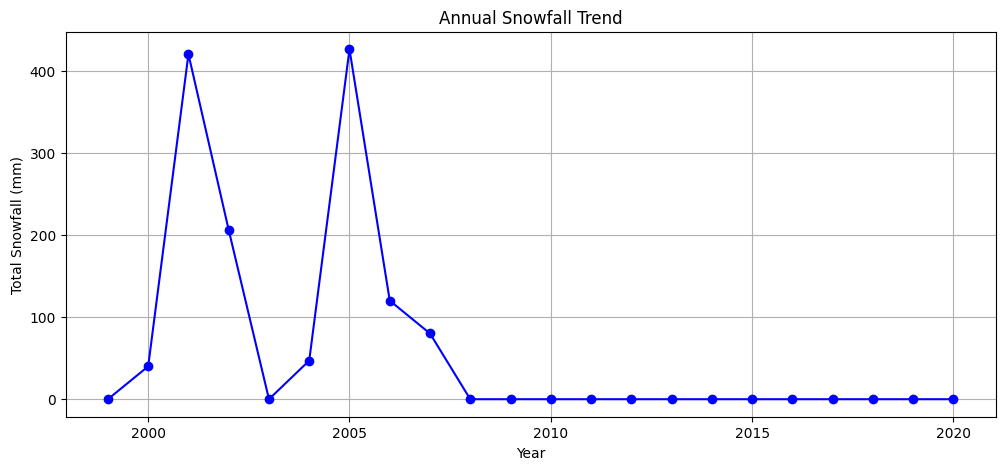

In [51]:
# Group by year and sum snowfall
df_weather['Year'] = df_weather.index.year
annual_snowfall = df_weather.groupby('Year')['SNOW'].sum()

# Display annual snowfall statistics
print(annual_snowfall.describe())
print(annual_snowfall)


plt.figure(figsize=(12, 5))
plt.plot(annual_snowfall.index, annual_snowfall.values, marker='o', linestyle='-', color='b')
plt.xlabel("Year")
plt.ylabel("Total Snowfall (mm)")
plt.title("Annual Snowfall Trend")
plt.grid(True)
plt.show()


In [52]:
# Convert to binary snowfall occurrence (1 if snow > 0 on a given day)
df_weather['Snow_Occurred'] = (df_weather['SNOW'] > 0).astype(int)

# Count the number of snow days per year
annual_snow_days = df_weather.groupby('Year')['Snow_Occurred'].sum()

# Display annual snow day statistics
print(annual_snow_days.describe())
print(annual_snow_days)


count    22.000000
mean      3.500000
std       6.337718
min       0.000000
25%       0.000000
50%       0.000000
75%       5.500000
max      20.000000
Name: Snow_Occurred, dtype: float64
Year
1999     0
2000    10
2001    19
2002     9
2003     0
2004    11
2005    20
2006     7
2007     1
2008     0
2009     0
2010     0
2011     0
2012     0
2013     0
2014     0
2015     0
2016     0
2017     0
2018     0
2019     0
2020     0
Name: Snow_Occurred, dtype: int64


No significant snowfall activity before 2008, in fact after 2008 - there is 0 snowfall occurences. This means snowfall is not a useful predictor, beyond 2008 at least. Model will not be able to learn meaningfull patterns so instead I will focus on temperature and precipiation.

### Checking for outliers?

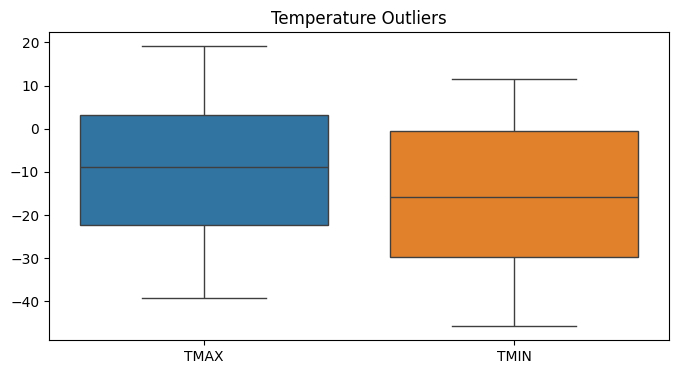

Number of TMAX outliers: 0
Number of TMIN outliers: 0


In [53]:
# Create a boxplot in attempts to visualise outliers
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_weather[['TMAX', 'TMIN']])
plt.title("Temperature Outliers")
plt.show()

# Calculate the IQR for TMAX and TMIN
Q1 = df_weather[['TMAX', 'TMIN']].quantile(0.25)
Q3 = df_weather[['TMAX', 'TMIN']].quantile(0.75)
IQR = Q3 - Q1

# Define upper and lower bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify any possible outliers
outliers_TMAX = (df_weather["TMAX"] < lower_bound["TMAX"]) | (df_weather["TMAX"] > upper_bound["TMAX"])
outliers_TMIN = (df_weather["TMIN"] < lower_bound["TMIN"]) | (df_weather["TMIN"] > upper_bound["TMIN"])

# Output the number of outliers
print("Number of TMAX outliers:", outliers_TMAX.sum())
print("Number of TMIN outliers:", outliers_TMIN.sum())

The whiskers or lines extending beyond the box represent the range within 1.5xIQR of the quartiles, and since there are no points/dots outside this range - there seem to be no outliers. TMAX and TMIN appear to behave normally and have expected seasonal variation without any extreme values, well distributed data.

/tmp/ipython-input-4270392053.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


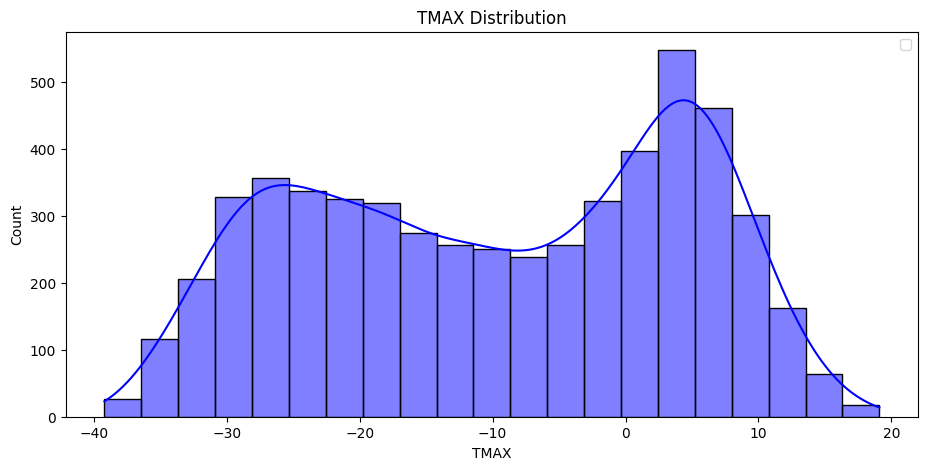

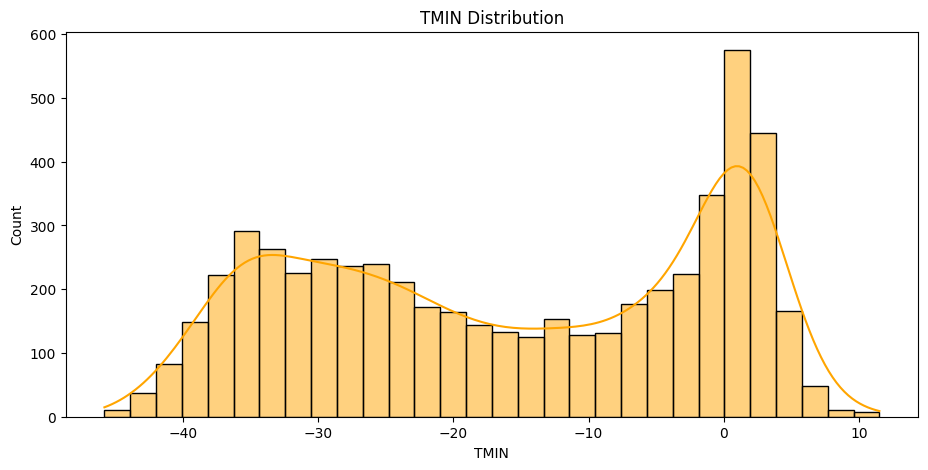

In [54]:
# Plotting histograms for TMAX and TMIN
plt.figure(figsize=(11, 5))
sns.histplot(df_weather["TMAX"], color="blue", kde=True)
plt.title("TMAX Distribution")
plt.legend()
plt.show()

plt.figure(figsize=(11, 5))
sns.histplot(df_weather["TMIN"], color="orange", bins=30, kde=True)
plt.xlabel("TMIN")
plt.ylabel("Count")
plt.title("TMIN Distribution")
plt.show()


Both distributions are bimodal with TMIN having a lower temperature range than TMAX as expected since it represents the coldest temperature of the day. This suggests nights tend to be much colder - which is a typical diurnal cycle behaviour.

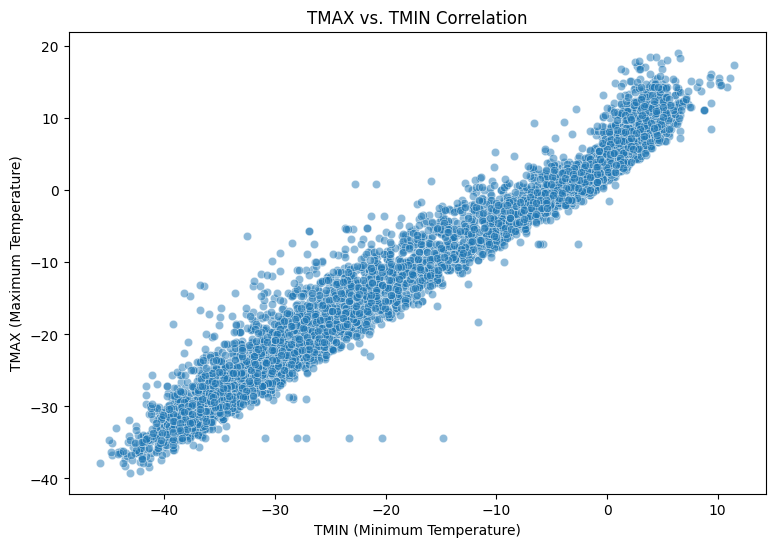

Pearson Correlation Coefficient: 0.98


In [55]:
# Plots a scatterplot of a comparison of TMAX and TMIN
plt.figure(figsize=(9, 6))
sns.scatterplot(x=df_weather["TMIN"], y=df_weather["TMAX"], alpha=0.5)
plt.xlabel("TMIN (Minimum Temperature)")
plt.ylabel("TMAX (Maximum Temperature)")
plt.title("TMAX vs. TMIN Correlation")
plt.show()

# Calculates and displays the correlation coefficient
correlation = df_weather["TMIN"].corr(df_weather["TMAX"])
print(f"Pearson Correlation Coefficient: {correlation:.2f}")

Strong positive correlation with an almost perfect linear relationship between TMAX and TMIN which means as TMIN increases, TMAX also increases as expected.

TMIN is a strong indicator/predictor of TMAX...

📊 Precipitation Summary Statistics:
count    5566.000000
mean        0.097863
std         0.313664
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.384390
Name: PRCP, dtype: float64

Outlier Summary:
Number of PRCP outliers: 894
Upper Bound: 0.000, Lower Bound: 0.000


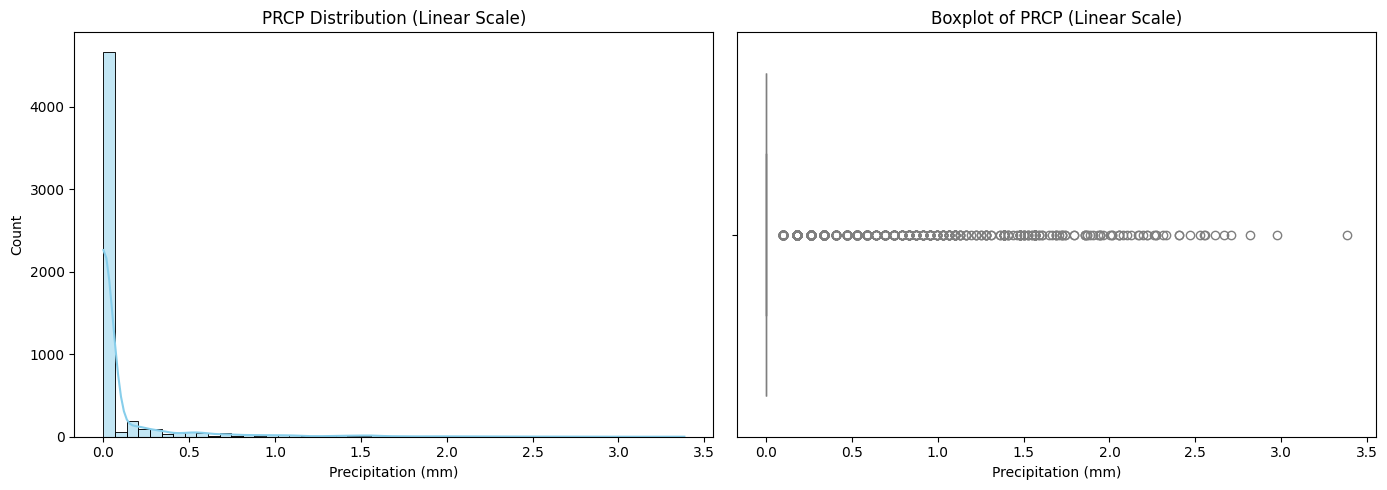

In [56]:
# Summary statistics
print("📊 Precipitation Summary Statistics:")
print(df_weather['PRCP'].describe())

# Calculate IQR
Q1_prcp = df_weather['PRCP'].quantile(0.25)
Q3_prcp = df_weather['PRCP'].quantile(0.75)
IQR_prcp = Q3_prcp - Q1_prcp

# Define outlier bounds
lower_bound_prcp = Q1_prcp - 1.5 * IQR_prcp
upper_bound_prcp = Q3_prcp + 1.5 * IQR_prcp

# Identify outliers
outliers_prcp = (df_weather['PRCP'] < lower_bound_prcp) | (df_weather['PRCP'] > upper_bound_prcp)
print(f"\nOutlier Summary:")
print(f"Number of PRCP outliers: {outliers_prcp.sum()}")
print(f"Upper Bound: {upper_bound_prcp:.3f}, Lower Bound: {lower_bound_prcp:.3f}")

# Plot distribution and boxplot
plt.figure(figsize=(14, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df_weather['PRCP'], bins=50, kde=True, color='skyblue')
plt.title("PRCP Distribution (Linear Scale)")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Count")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df_weather['PRCP'], color='lightgray')
plt.title("Boxplot of PRCP (Linear Scale)")
plt.xlabel("Precipitation (mm)")

plt.tight_layout()
plt.show()



The first histogram shows that most precipitation values are close to zero, with a long right tail indicating occasional heavier rainfall. The second boxplot reveals seasonal variation, with summer months showing greater variability and more frequent high-precipitation outliers.

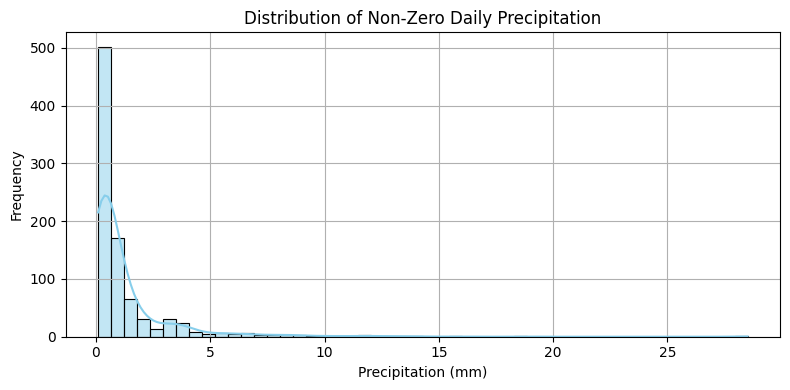

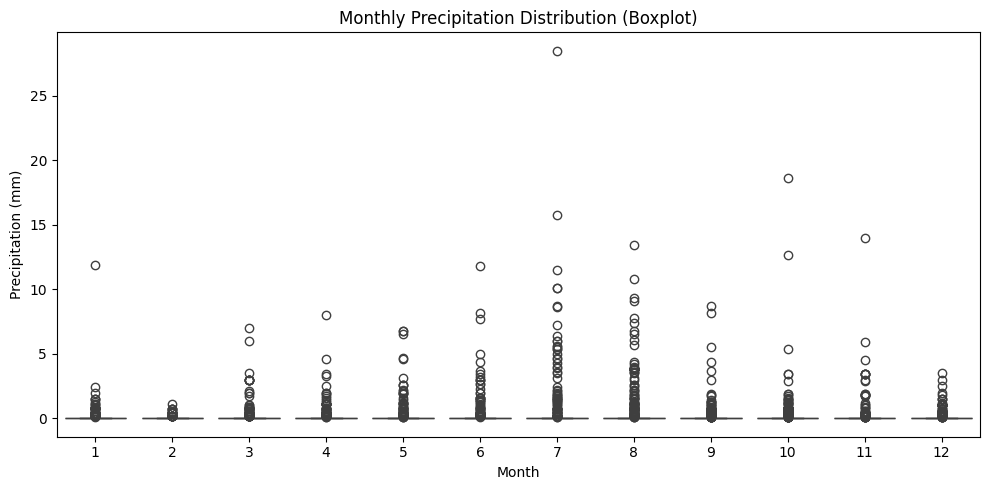

In [57]:
# Create a new column for actual PRCP values
df_weather['PRCP_actual'] = np.expm1(df_weather['PRCP'])

# Filter data to include only non-zero actual precipitation
non_zero_prcp = df_weather[df_weather['PRCP_actual'] > 0]

# Plot a histogram of non-zero actual precipitation
plt.figure(figsize=(8, 4))
sns.histplot(non_zero_prcp['PRCP_actual'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Non-Zero Daily Precipitation")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Extract month for analysis
df_weather['Month'] = df_weather.index.month

# Plot a boxplot of monthly precipitation distribution
plt.figure(figsize=(10, 5))
sns.boxplot(x='Month', y='PRCP_actual', data=df_weather)
plt.title("Monthly Precipitation Distribution (Boxplot)")
plt.xlabel("Month")
plt.ylabel("Precipitation (mm)")
plt.tight_layout()
plt.show()

This histogram and boxplot (including zeros) confirm that dry days dominate the dataset, leading to a highly skewed distribution. Overall, precipitation is infrequent but occasionally intense, and its distribution is both sparse and seasonal.

## Task 1: Predicting Climate (long-term)

In this section, we predict future **climate variables**, including **temperature (TMAX and TMIN)** and **precipitation (PRCP)**, using two different machine learning models: **Long Short-Term Memory (LSTM)** and **XGBoost**. Both models are well-suited for time series forecasting, but they approach the problem in different ways:

1. **LSTM Model**: The LSTM model is a type of **Recurrent Neural Network (RNN)** that is particularly effective at capturing **long-term dependencies** and **seasonal patterns** in time series data. It will be used to model and forecast **climate trends** over time.
   
2. **XGBoost Model**: XGBoost is a powerful **gradient boosting algorithm** that performs well on structured/tabular data. In this task, we use XGBoost to predict future climate variables based on **historical climate data**. While not specifically designed for time series forecasting, XGBoost can still capture **trends and relationships** in the data when paired with appropriate feature engineering.

The key steps in this task include:
1. **Data Preparation**: The climate data will be processed and formatted for both the LSTM and XGBoost models. For LSTM, this involves transforming the data into sequences, while for XGBoost, we'll create **lag features** and other temporal features.
2. **Training the Models**: Both the LSTM and XGBoost models will be trained on historical climate data to learn the underlying patterns in **temperature** and **precipitation**.
3. **Forecasting**: After training, the models will be used to forecast **future climate values** for TMAX, TMIN, and PRCP over the next **20 years (2025–2044)**.
4. **Performance Evaluation**: The models will be evaluated using performance metrics such as **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)** to compare their accuracy and suitability for predicting future climate conditions.

By comparing the performance of both models, we aim to understand how well each approach can predict future **climate trends** and assess their potential for **long-term forecasting**.

### Using LTSM model

In [58]:
# Feature columns
features = ['TMAX', 'TMIN', 'PRCP', 'Month_sin', 'Month_cos']
target = ['TMAX', 'TMIN', 'PRCP']

# Adds Month_sin and Month_cos to df_monthly:
df_monthly = df_monthly.reset_index() #Reset index to access the 'date' column
df_monthly['Month'] = df_monthly['date'].dt.month
df_monthly['Month_sin'] = np.sin(2 * np.pi * df_monthly['Month'] / 12)
df_monthly['Month_cos'] = np.cos(2 * np.pi * df_monthly['Month'] / 12)

# Update features list:
features = ['TMAX', 'TMIN', 'PRCP', 'Month_sin', 'Month_cos'] # Include new features

# Normalize features
scaler = MinMaxScaler()
df_scaled = df_monthly.copy()
df_scaled[features] = scaler.fit_transform(df_monthly[features])

# Prepare sequence data (12-month lookback to predict 13th month)
def create_sequences(data, sequence_length=12):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length][:3])  # Only TMAX, TMIN, PRCP
    return np.array(X), np.array(y)

data_array = df_scaled[features].values
X, y = create_sequences(data_array)

# Split based on date
dates = df_monthly['date'].values[12:]
split_idx = np.where(pd.to_datetime(dates) < np.datetime64("2020-01"))[0][-1] + 1

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
dates_test = dates[split_idx:]

In [59]:
# Builds LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train.shape[1]))  # Output layer matches target size (3)

model.compile(optimizer='adam', loss='mae')

# Trains Model
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=16, callbacks=[early_stop], verbose=1)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.2780 - val_loss: 0.1948
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1985 - val_loss: 0.1677
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1739 - val_loss: 0.1364
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1468 - val_loss: 0.0841
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1033 - val_loss: 0.0546
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1030 - val_loss: 0.0734
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0940 - val_loss: 0.0749
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1033 - val_loss: 0.0671
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1004 - val_loss: 0.0676
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0958 - val_loss: 0.0575


In [60]:
#  Predict on 2021
y_pred = model.predict(X_test)

# Inverse scale for interpretability
pad = np.zeros((len(y_pred), 2))
y_pred_inv = scaler.inverse_transform(np.hstack([y_pred, pad]))[:, :3]
y_test_inv = scaler.inverse_transform(np.hstack([y_test, pad]))[:, :3]

# Evaluation
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"LSTM Climate MAE (2021): {mae:.2f}")
print(f"LSTM Climate R² Score (2021): {r2:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
LSTM Climate MAE (2021): 1.32
LSTM Climate R² Score (2021): 0.71


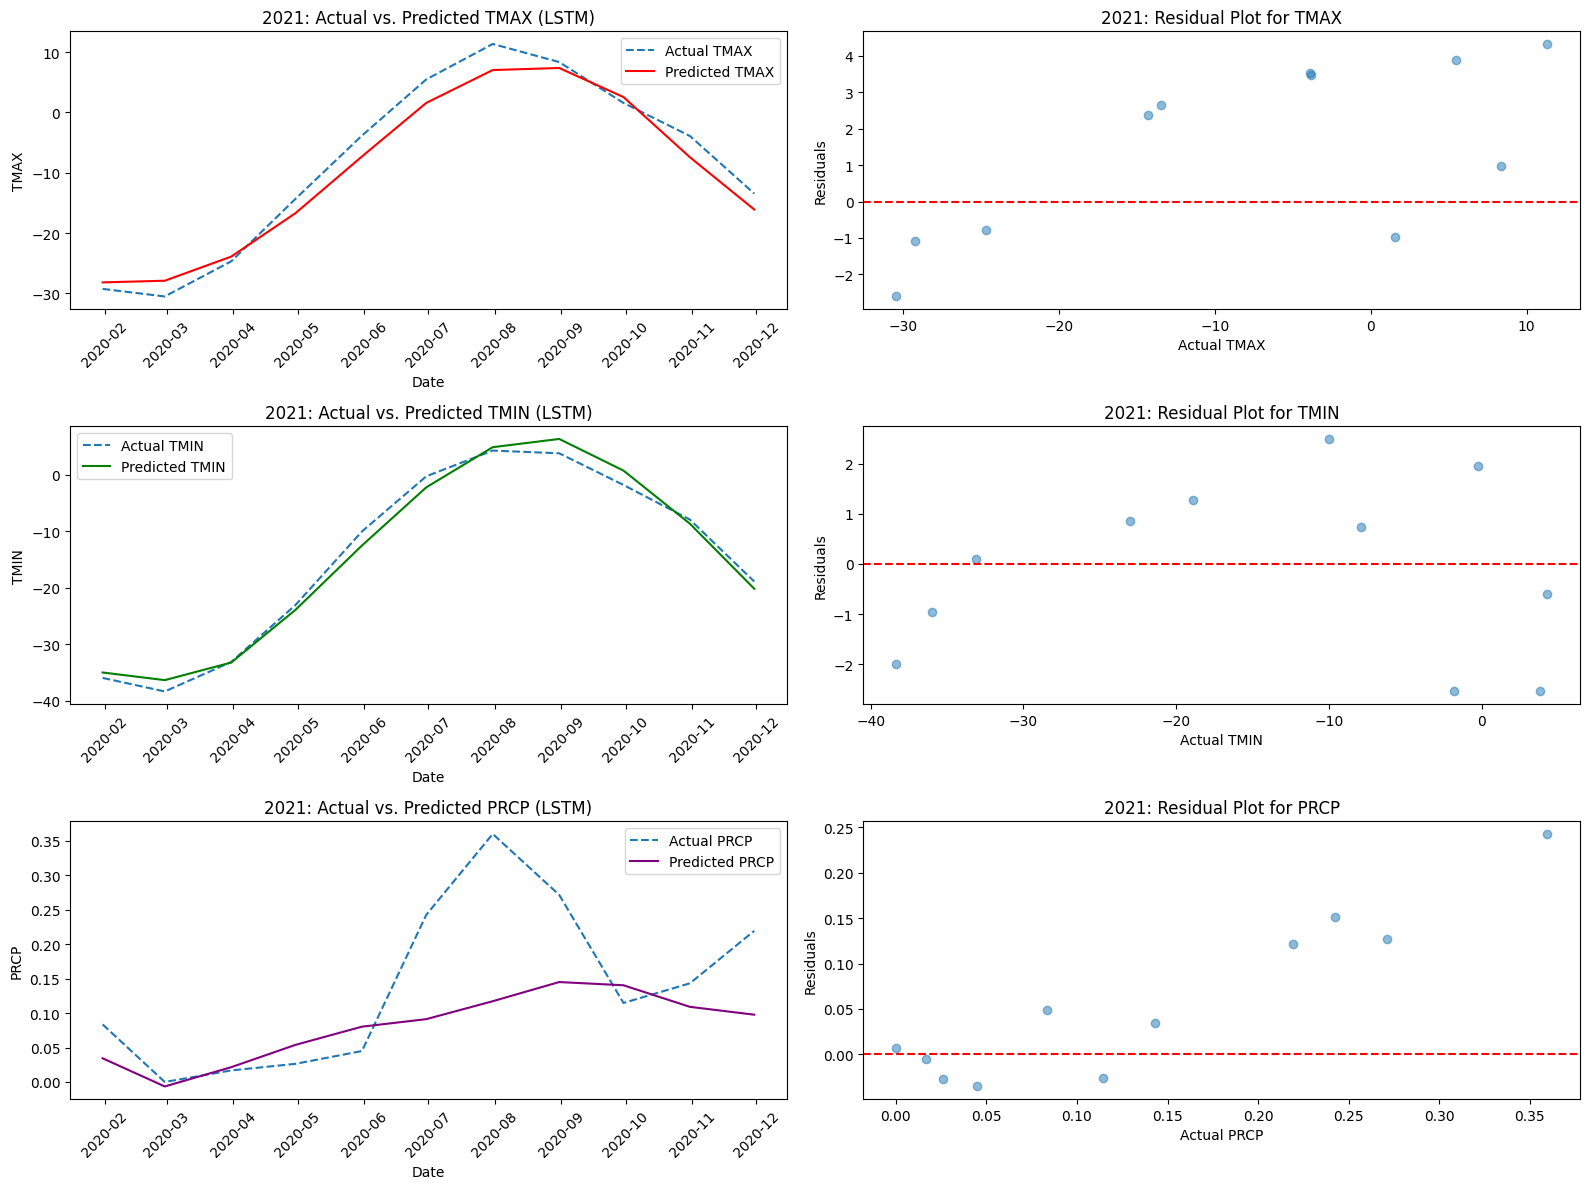

In [61]:
# Plot Actual vs Predicted with Residuals
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
variables = ['TMAX', 'TMIN', 'PRCP']
colors = ['red', 'green', 'purple']

for i in range(3):
    # Actual vs Predicted
    axes[i, 0].plot(dates_test, y_test_inv[:, i], label=f"Actual {variables[i]}", linestyle='--')
    axes[i, 0].plot(dates_test, y_pred_inv[:, i], label=f"Predicted {variables[i]}", color=colors[i])
    axes[i, 0].set_title(f"2021: Actual vs. Predicted {variables[i]} (LSTM)")
    axes[i, 0].set_xlabel("Date")
    axes[i, 0].set_ylabel(variables[i])
    axes[i, 0].legend()
    axes[i, 0].tick_params(axis='x', rotation=45)

    # Residual plot
    residuals = y_test_inv[:, i] - y_pred_inv[:, i]
    axes[i, 1].scatter(y_test_inv[:, i], residuals, alpha=0.5)
    axes[i, 1].axhline(0, color='red', linestyle='dashed')
    axes[i, 1].set_title(f"2021: Residual Plot for {variables[i]}")
    axes[i, 1].set_xlabel(f"Actual {variables[i]}")
    axes[i, 1].set_ylabel("Residuals")

plt.tight_layout()
plt.show()

* **Actual vs Predicted TMAX**: The plot compares actual vs predicted TMAX for 2021, showing a reasonable fit but with some discrepancies in certain months.
* **Actual vs Predicted TMIN**: Similar to TMAX, TMIN shows a good overall match, but slight differences in the predicted values are visible.
* **Actual vs Predicted PRCP**: The predicted precipitation closely follows the actual data, though the model underperforms during peak rainfall months.
* **Residuals** : The residual plots for each variable show small variations around 0, indicating that while the model captures general trends, it struggles with outliers, particularly for PRCP.




### Using XGBoost model

In [62]:
# Convert daily data to weekly & monthly averages
df_weekly = df_weather.resample("W").mean()  # Weekly Averages
df_monthly = df_weather.resample("M").mean()  # Monthly Averages

# Reset index for modeling
df_weekly.reset_index(inplace=True)
df_monthly.reset_index(inplace=True)

# Add cyclical encoding for seasonality
df_monthly['Month'] = df_monthly['date'].dt.month
df_monthly['Year'] = df_monthly['date'].dt.year

# Convert month into cyclic feature (to represent seasonality)
df_monthly['Month_sin'] = np.sin(2 * np.pi * df_monthly['Month'] / 12)
df_monthly['Month_cos'] = np.cos(2 * np.pi * df_monthly['Month'] / 12)

# Lag features (previous years' climate as input)
df_monthly['TMAX_lag12'] = df_monthly['TMAX'].shift(12)
df_monthly['TMIN_lag12'] = df_monthly['TMIN'].shift(12)
df_monthly['PRCP_lag12'] = df_monthly['PRCP'].shift(12)
df_monthly['TMAX_lag24'] = df_monthly['TMAX'].shift(24)
df_monthly['TMIN_lag24'] = df_monthly['TMIN'].shift(24)
df_monthly['PRCP_lag24'] = df_monthly['PRCP'].shift(24)


/tmp/ipython-input-2158162539.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_weather.resample("M").mean()  # Monthly Averages


In [63]:
# Drop NaN values (from lag features)
df_monthly.dropna(inplace=True)

# Define input features and target variable
features = ['TMAX', 'TMIN', 'PRCP', 'Month_sin', 'Month_cos',
            'TMAX_lag12', 'TMIN_lag12', 'PRCP_lag12',
            'TMAX_lag24', 'TMIN_lag24', 'PRCP_lag24']

target = ['TMAX', 'TMIN', 'PRCP']  # Predict next year's climate

# Train on data before 2020, test on 2020 climate data
train = df_monthly[df_monthly['Year'] < 2020]
test = df_monthly[df_monthly['Year'] == 2020]

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Train XGBoost model for multi-output regression
model_climate = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_climate.fit(X_train, y_train)

# Predict the next year's climate
y_pred_climate = model_climate.predict(X_test)

# Convert predictions to DataFrame
y_pred_climate_df = pd.DataFrame(y_pred_climate, columns=target, index=y_test.index)

# Compute residuals
residuals = y_test - y_pred_climate_df

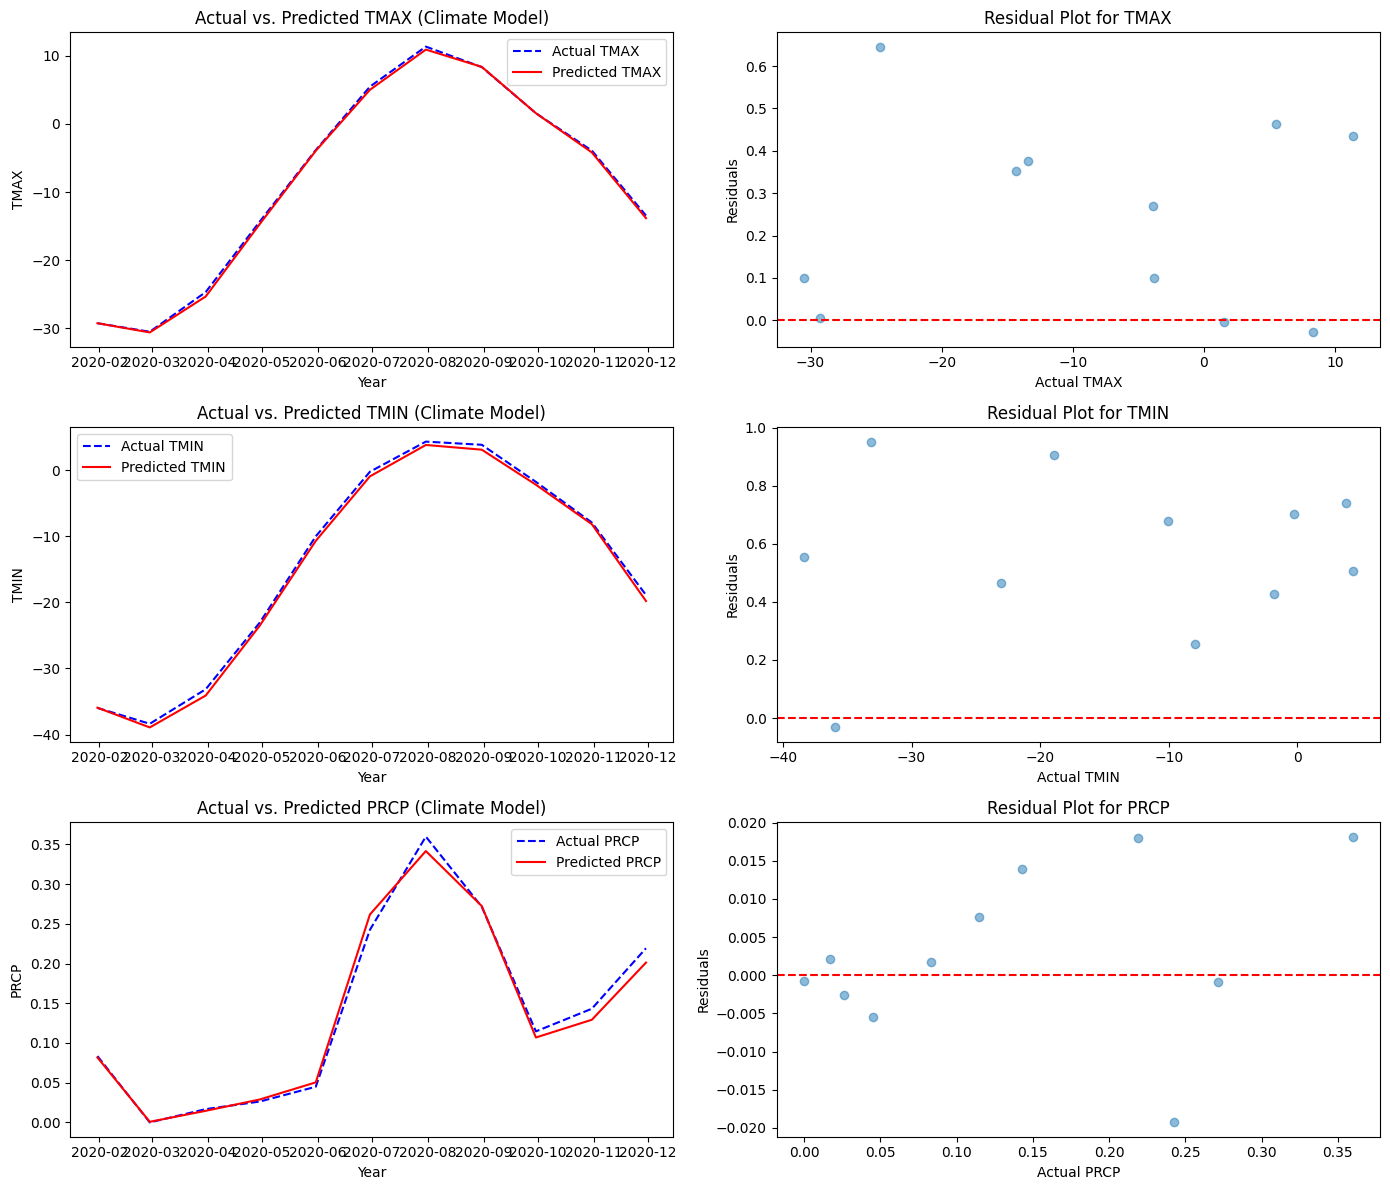

Climate Model MAE: 0.28
R² Score: 1.00


In [64]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))

for i, col in enumerate(target):
    # Actual vs Predicted
    axes[i, 0].plot(test['date'], y_test[col], label=f"Actual {col}", color="blue", linestyle='dashed')
    axes[i, 0].plot(test['date'], y_pred_climate_df[col], label=f"Predicted {col}", color="red")
    axes[i, 0].set_xlabel("Year")
    axes[i, 0].set_ylabel(col)
    axes[i, 0].legend()
    axes[i, 0].set_title(f"Actual vs. Predicted {col} (Climate Model)")

    # Residuals
    axes[i, 1].scatter(y_test[col], residuals[col], alpha=0.5)
    axes[i, 1].axhline(0, color='red', linestyle='dashed')
    axes[i, 1].set_xlabel(f"Actual {col}")
    axes[i, 1].set_ylabel("Residuals")
    axes[i, 1].set_title(f"Residual Plot for {col}")

plt.tight_layout()
plt.show()

# Compute errors
mae_climate = mean_absolute_error(y_test, y_pred_climate_df)
r2_climate = r2_score(y_test, y_pred_climate_df)

print(f"Climate Model MAE: {mae_climate:.2f}")
print(f"R² Score: {r2_climate:.2f}")

Adding more lag features increased the MAE slightly. This might be due to increased complexity without meaningful new information. You can experiment by selectively removing the lag features (e.g., keeping only 12-month and 24-month lags) and checking if the MAE improves.

* **Actual vs Predicted TMAX**: The plot compares actual vs predicted TMAX for 2021, showing a good overall fit, but some smoothing in the predicted values, missing fine variations.
* **Actual vs Predicted TMAX**: The TMIN plot similarly matches the overall trend, but the XGBoost model's predictions lack sensitivity to some fluctuations, especially in colder months.
* **Actual vs Predicted PRCP**: Precipitation predictions from XGBoost follow the overall trend but miss finer seasonal peaks and valleys.
* **Residuals**: The residual plots show minimal errors around 0, with a few outliers indicating occasional mispredictions, particularly for PRCP.





### Comparison between XGB and LTSM model

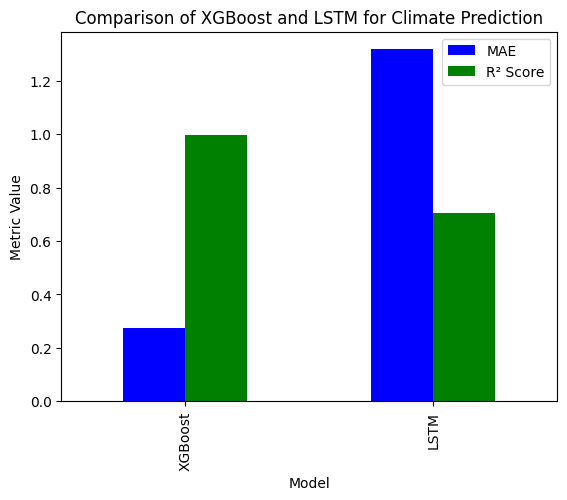

In [65]:
# Compare MAE and R² Score for both models
comparison_metrics = pd.DataFrame({
    'Model': ['XGBoost', 'LSTM'],
    'MAE': [mae_climate, mae],
    'R² Score': [r2_climate, r2]
})

comparison_metrics.plot(kind='bar', x='Model', y=['MAE', 'R² Score'], color=['blue', 'green'], legend=True)
plt.title('Comparison of XGBoost and LSTM for Climate Prediction')
plt.ylabel('Metric Value')
plt.show()

## Task 2: Predicting Weather (short-term)

In this task, we aim to predict daily weather parameters (temperature and precipitation) using machine learning models. The primary focus is to build a model that can accurately forecast weather patterns based on historical data. We will experiment with multiple models, such as **XGBoost** and **LSTM**, and evaluate their performance using common metrics like **Mean Absolute Error (MAE)** and **Root Mean Squared Error (RMSE)**. The ultimate goal is to determine the best model for predicting weather variables, comparing their predictions to actual recorded data and analyzing the forecasted weather over different timeframes.

We will specifically focus on predicting **TMAX (maximum temperature)**, **TMIN (minimum temperature)**, and **PRCP (precipitation)** for a given station, comparing the results using both traditional machine learning and deep learning approaches.


### Using LTSM

In [80]:
# Filter and Scale
df_weather_daily = df_weather[["TMAX", "TMIN", "PRCP"]].copy()
df_weather_daily = df_weather_daily[df_weather_daily.index.year <= 2020]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_weather_daily)

In [81]:
# Create sequences
def create_sequences_with_dates(data, dates, seq_length=7):
    X, y, date_list = [], [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
        date_list.append(dates[i+seq_length])
    return np.array(X), np.array(y), np.array(date_list)

seq_length = 7
X_all, y_all, dates_all = create_sequences_with_dates(scaled_data, df_weather_daily.index, seq_length)

In [82]:
# Split into train (pre-2020) and test (2020 only)
train_mask = pd.to_datetime(dates_all).year < 2020
test_mask = pd.to_datetime(dates_all).year == 2020

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_test, y_test = X_all[test_mask], y_all[test_mask]
dates_test = dates_all[test_mask]

In [83]:
# Building LSTM Model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1])
])
model.compile(optimizer='adam', loss='mae')
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=16, callbacks=[early_stop], verbose=1)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1016 - val_loss: 0.0537
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0493 - val_loss: 0.0523
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0453 - val_loss: 0.0524
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0427 - val_loss: 0.0491
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0408 - val_loss: 0.0485
Epoch 6/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0405 - val_loss: 0.0494
Epoch 7/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0383 - val_loss: 0.0475
Epoch 8/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0370 - val_loss: 0.0467
Epoch 9/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0376 - val_loss: 0.0468
Epoch 10/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0384 - val_loss: 0.0464
Epoch 11/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0365 - val_loss: 0.0466
Epoch 12/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 

In [84]:
# Predictions
y_pred = model.predict(X_test)

# Inverse scale
y_test_inv = scaler.inverse_transform(np.hstack([y_test]))
y_pred_inv = scaler.inverse_transform(np.hstack([y_pred]))

mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)
print("LSTM MAE:", mae_lstm)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
LSTM MAE: 1.288718809612151


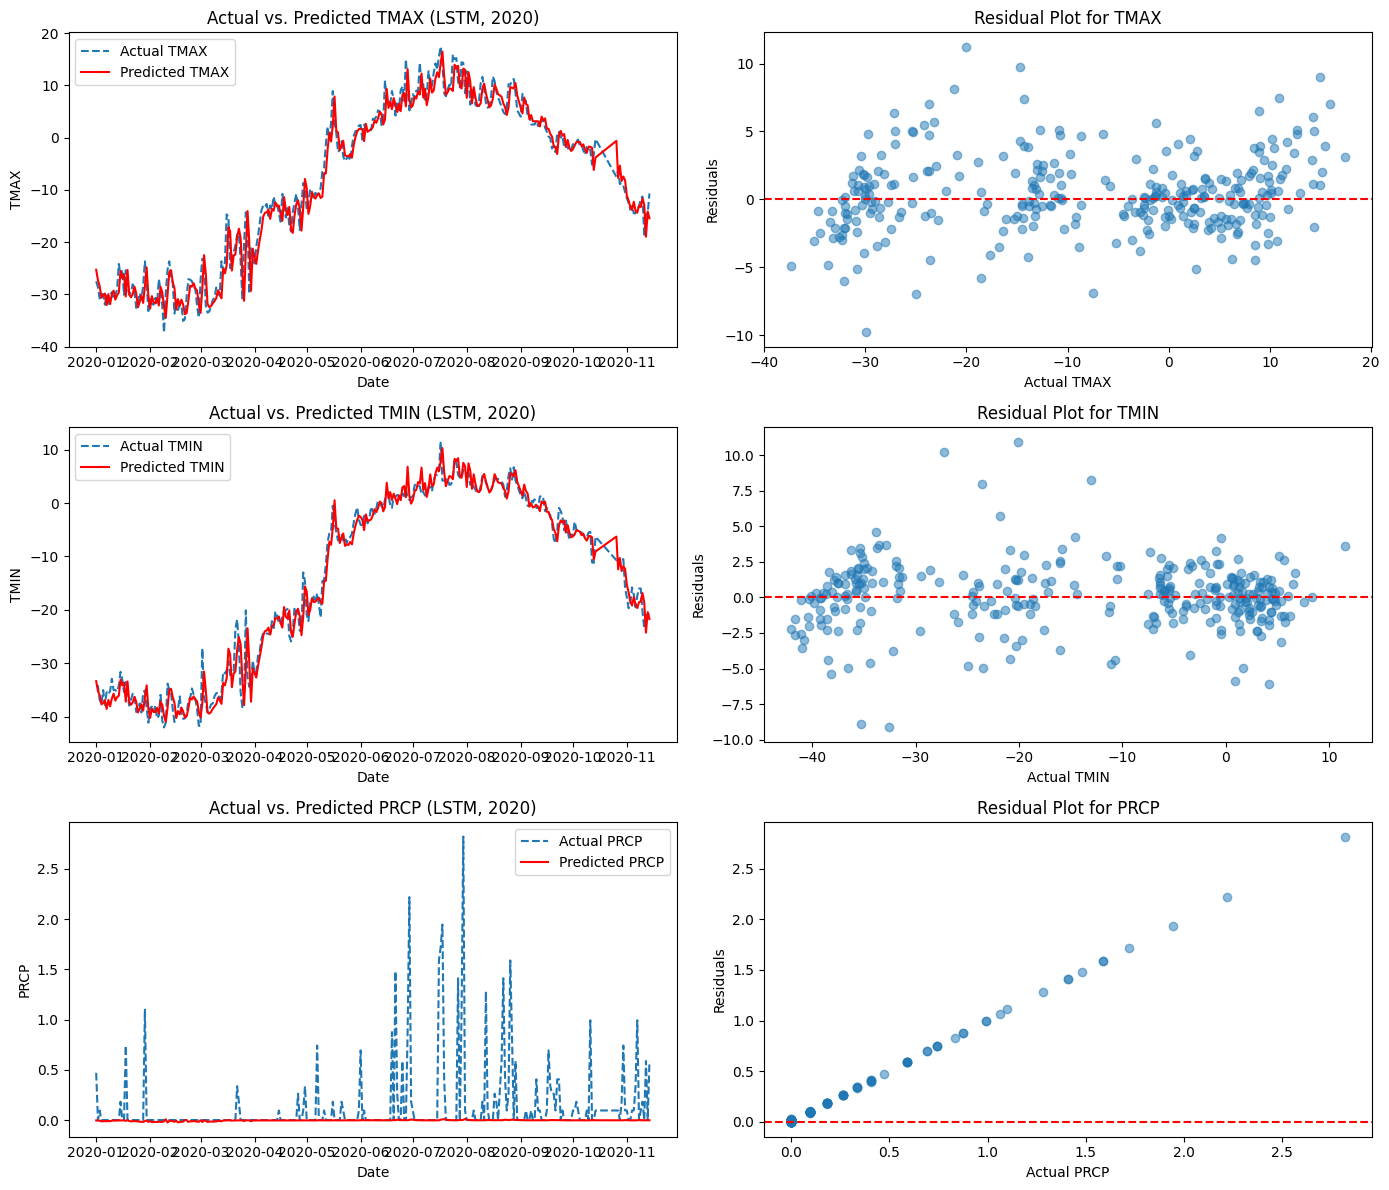

In [85]:
# Final Plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
labels = ['TMAX', 'TMIN', 'PRCP']

for i in range(3):
    # Actual vs Predicted
    axes[i, 0].plot(dates_test, y_test_inv[:, i], label=f"Actual {labels[i]}", linestyle='--')
    axes[i, 0].plot(dates_test, y_pred_inv[:, i], label=f"Predicted {labels[i]}", color='red')
    axes[i, 0].set_title(f"Actual vs. Predicted {labels[i]} (LSTM, 2020)")
    axes[i, 0].set_xlabel("Date")
    axes[i, 0].set_ylabel(labels[i])
    axes[i, 0].legend()

    # Residuals
    residuals = y_test_inv[:, i] - y_pred_inv[:, i]
    axes[i, 1].scatter(y_test_inv[:, i], residuals, alpha=0.5)
    axes[i, 1].axhline(0, color='red', linestyle='dashed')
    axes[i, 1].set_xlabel(f"Actual {labels[i]}")
    axes[i, 1].set_ylabel("Residuals")
    axes[i, 1].set_title(f"Residual Plot for {labels[i]}")

plt.tight_layout()
plt.show()

* **Actual vs Predicted TMAX (LSTM, 2020)**: This plot shows the predicted vs actual TMAX (maximum temperature) for the year 2020. The model successfully captures the overall trends, but discrepancies can be seen in certain months, especially during the sharp temperature peaks and drops.
  
* **Actual vs Predicted TMIN (LSTM, 2020)**: This plot demonstrates the predicted vs actual TMIN (minimum temperature) for 2020. The LSTM model exhibits a reasonable fit, though the predicted values deviate slightly from actual values during the sharpest changes in temperature.

* **Actual vs Predicted PRCP (LSTM, 2020)**: The predicted PRCP (precipitation) is compared with actual data for the year 2020. While the model captures the overall trend, some discrepancies are visible in months with peak precipitation, where the predicted values tend to be underestimated.

* **Residual Plots for TMAX, TMIN, and PRCP**: These residual plots show the difference between actual and predicted values. Most residuals are centered around zero, suggesting the model fits the general trends well. However, larger residuals can be observed, particularly during months with extreme values of TMAX, TMIN, or PRCP.


### Using XGBoost model

In [86]:
# Convert daily data to weekly & monthly averages
df_weather.index = pd.to_datetime(df_weather.index)
df_daily = df_weather.copy()

# Add cyclical encoding for seasonality
df_daily['Month'] = df_daily.index.month
df_daily['DayOfWeek'] = df_daily.index.dayofweek
df_daily['Month_sin'] = np.sin(2 * np.pi * df_daily['Month'] / 12)
df_daily['Month_cos'] = np.cos(2 * np.pi * df_daily['Month'] / 12)

# Lag features (past weather conditions)
for lag in [1, 3, 7, 14, 30]:
    df_daily[f'TMAX_lag{lag}'] = df_daily['TMAX'].shift(lag)
    df_daily[f'TMIN_lag{lag}'] = df_daily['TMIN'].shift(lag)
    df_daily[f'PRCP_lag{lag}'] = df_daily['PRCP'].shift(lag)

# Rolling statistics for trends & variability
df_daily['TMAX_rolling_mean7'] = df_daily['TMAX'].rolling(window=7).mean()
df_daily['TMIN_rolling_mean7'] = df_daily['TMIN'].rolling(window=7).mean()
df_daily['PRCP_rolling_sum7'] = df_daily['PRCP'].rolling(window=7).sum()
df_daily['TMAX_rolling_std7'] = df_daily['TMAX'].rolling(window=7).std()
df_daily['TMIN_rolling_std7'] = df_daily['TMIN'].rolling(window=7).std()

# Day-to-day change (delta feature)
df_daily['TMAX_delta'] = df_daily['TMAX'].diff()
df_daily['TMIN_delta'] = df_daily['TMIN'].diff()
df_daily['PRCP_delta'] = df_daily['PRCP'].diff()

# Drop NaN values from rolling stats and lags
df_daily.dropna(inplace=True)



In [87]:
# Define input features and target variable
features = [
    'TMAX', 'TMIN', 'PRCP', 'Month_sin', 'Month_cos', 'DayOfWeek'
] + [
    f'TMAX_lag{lag}' for lag in [1, 3, 7, 14, 30]
] + [
    f'TMIN_lag{lag}' for lag in [1, 3, 7, 14, 30]
] + [
    f'PRCP_lag{lag}' for lag in [1, 3, 7, 14, 30]
] + [
    'TMAX_rolling_mean7', 'TMIN_rolling_mean7', 'PRCP_rolling_sum7',
    'TMAX_rolling_std7', 'TMIN_rolling_std7',
    'TMAX_delta', 'TMIN_delta', 'PRCP_delta'
]


target = ['TMAX', 'TMIN', 'PRCP']  # Predict next day's weather

# Train-test split (train on data before 2020, test on 2020)
train = df_daily[df_daily.index.year < 2020]
test = df_daily[df_daily.index.year == 2020]

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Train XGBoost model for multi-output regression
model_weather = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_weather.fit(X_train, y_train)

# Predict the next day's weather
y_pred_weather = model_weather.predict(X_test)

Weather Model MAE: 0.05
Naive Baseline MAE: 1.34


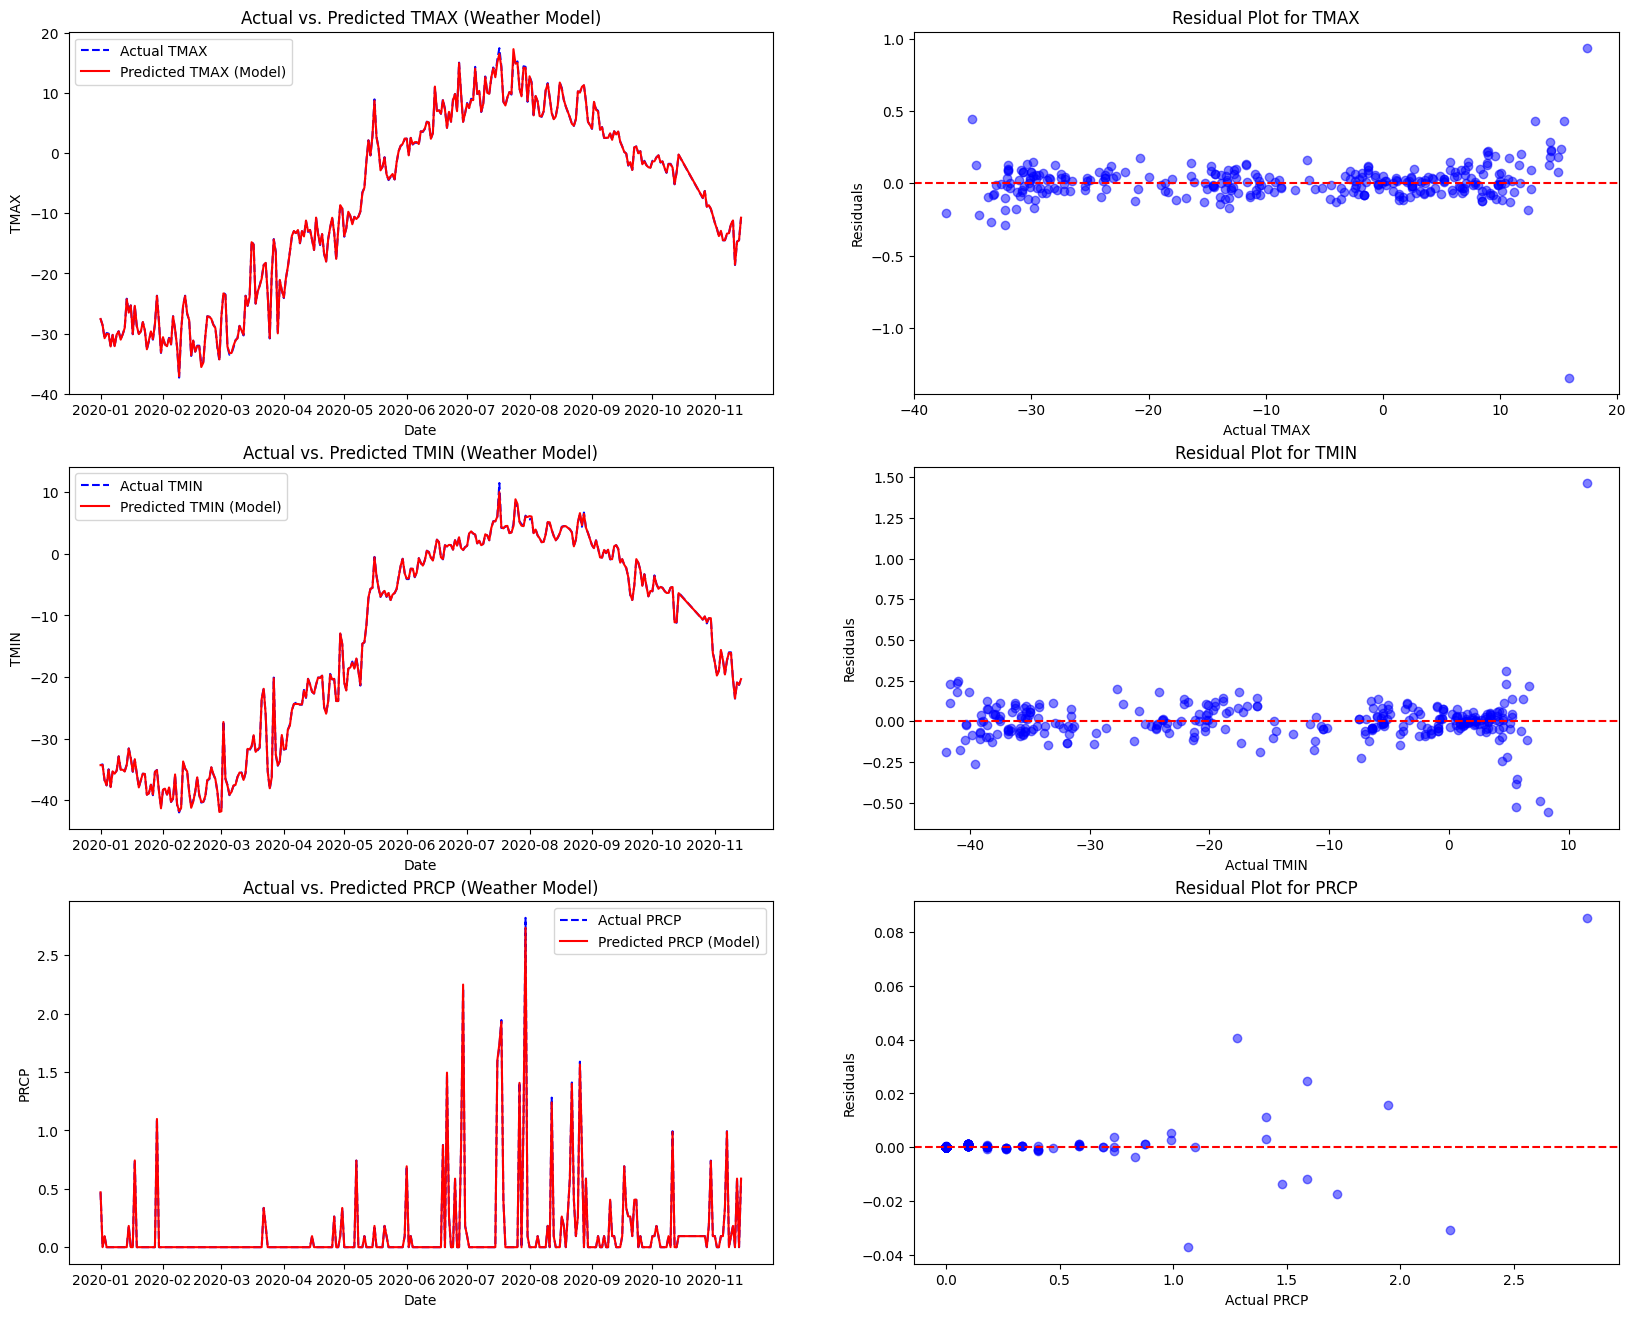

In [88]:
# Compute errors
mae_weather = mean_absolute_error(y_test, y_pred_weather)
print(f"Weather Model MAE: {mae_weather:.2f}")

# Naive baseline (tomorrow = today)
naive_pred = test[target].shift(1).dropna()
naive_mae = mean_absolute_error(naive_pred, y_test.loc[naive_pred.index])
print(f"Naive Baseline MAE: {naive_mae:.2f}")

# Compute residuals
residuals = y_test - pd.DataFrame(y_pred_weather, columns=target, index=y_test.index) # Convert to DataFrame with correct index

# Plot actual vs predicted weather
plt.figure(figsize=(20, 16))

for i, col in enumerate(target):
    plt.subplot(3, 2, 2 * i + 1)
    plt.plot(test.index, y_test[col], label=f"Actual {col}", color="blue", linestyle='dashed')
    plt.plot(test.index, y_pred_weather[:, i], label=f"Predicted {col} (Model)", color="red")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.title(f"Actual vs. Predicted {col} (Weather Model)")

    # Residual plot
    plt.subplot(3, 2, 2 * i + 2)
    plt.scatter(y_test[col], residuals[col], color='blue', alpha=0.5)  # Access residuals using column name
    plt.axhline(y=0, color='red', linestyle='dashed')
    plt.xlabel(f"Actual {col}")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot for {col}")

* **Actual vs Predicted TMAX (XGBoost, 2020)**: This plot compares actual vs predicted TMAX for 2020 using the XGBoost model. The predictions are almost perfectly aligned with the actual values, showing very little deviation, particularly in the months with temperature extremes. The model performs excellently here.
  
* **Actual vs Predicted TMIN (XGBoost, 2020)**: Similar to TMAX, the TMIN predictions from XGBoost show excellent accuracy, with minimal discrepancies between actual and predicted values. The model captures the sharp changes in temperature well.

* **Actual vs Predicted PRCP (XGBoost, 2020)**: The predicted PRCP (precipitation) data closely follows the actual values for 2020. XGBoost performs very well in tracking changes in rainfall, closely matching the observed values, even during peak rainfall periods.

* **Residual Plots for TMAX, TMIN, and PRCP (XGBoost)**: The residuals for XGBoost show almost no deviation from zero, indicating that the model fits the data extremely well. Larger residuals are barely noticeable, reinforcing the high accuracy of the model.


Model improves over naive baseline by 96.21%


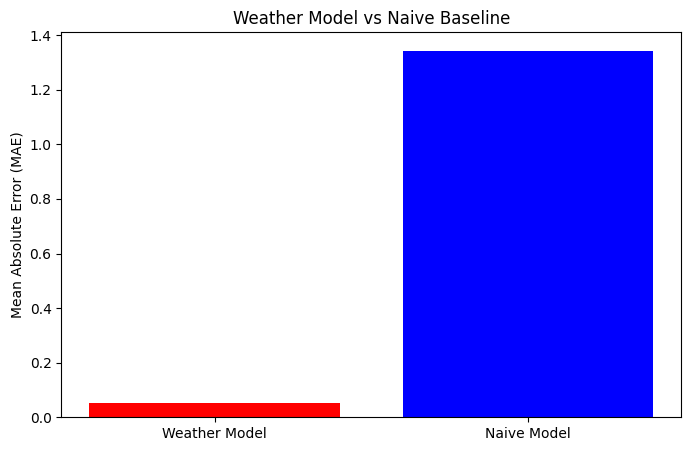

In [89]:
# Compare performance
improvement = ((naive_mae - mae_weather) / naive_mae) * 100
print(f"Model improves over naive baseline by {improvement:.2f}%")

# Plot comparison
plt.figure(figsize=(8, 5))
plt.bar(['Weather Model', 'Naive Model'], [mae_weather, naive_mae], color=['red', 'blue'])
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Weather Model vs Naive Baseline')
plt.show()

* **Weather Model (XGB) vs Naive Baseline (MAE Comparison)**: This bar plot compares the Mean Absolute Error (MAE) of the XGB weather model against the naive baseline model. The XGB weather model improves over the naive baseline by 96.21%, indicating that it performs much better than the naive baseline which uses a simple prediction strategy (such as predicting the mean of historical data).


### Comparison between XGB and LTSM model

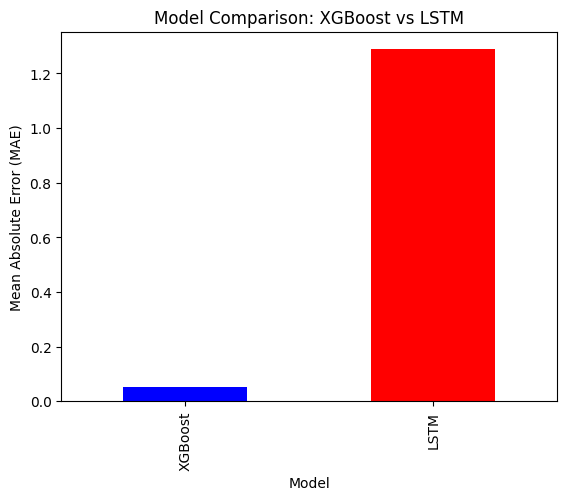

In [90]:
# Compare MAE of XGBoost and LSTM models



model_comparison = pd.DataFrame({
    'Model': ['XGBoost', 'LSTM'],
    'MAE': [mae_weather, mae_lstm]
})

model_comparison.plot(kind='bar', x='Model', y='MAE', color=['blue', 'red'], legend=False)
plt.title('Model Comparison: XGBoost vs LSTM')
plt.ylabel('Mean Absolute Error (MAE)')
plt.show()


## Extensions

### 1. Can you train a machine learning technique to predict 10 or 20 years into the future?

---

In [91]:
# Load your df_monthly with TMAX, TMIN, PRCP
# Add cyclical features
df_monthly['Month'] = df_monthly['date'].dt.month
df_monthly['Month_sin'] = np.sin(2 * np.pi * df_monthly['Month'] / 12)
df_monthly['Month_cos'] = np.cos(2 * np.pi * df_monthly['Month'] / 12)

# Feature and target setup
features = ['TMAX', 'TMIN', 'PRCP', 'Month_sin', 'Month_cos']
target = ['TMAX', 'TMIN', 'PRCP']

# Scale features
scaler = MinMaxScaler()
df_scaled = df_monthly.copy()
df_scaled[features] = scaler.fit_transform(df_scaled[features])


In [92]:
# Create sequences
def create_sequences(data, sequence_length=12):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length][:3])
    return np.array(X), np.array(y)

data_array = df_scaled[features].values
X, y = create_sequences(data_array)

# Train LSTM model
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(y.shape[1])
])
model.compile(optimizer='adam', loss='mae')
model.fit(X, y, epochs=100, batch_size=8, verbose=1)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3963
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2508
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2184
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1861
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1488
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1162
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1104
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1087
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0978
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0917
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0976
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0830
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0812
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0937
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0990
Epoch 

In [93]:
# Forecasting 20 years ahead
forecast_input = data_array[-12:].copy()
forecast_months = 20 * 12
forecast_preds = []
forecast_dates = [df_monthly['date'].iloc[-1] + pd.DateOffset(months=i+1) for i in range(forecast_months)]

for i in range(forecast_months):
    input_seq = np.expand_dims(forecast_input[-12:], axis=0)
    pred = model.predict(input_seq, verbose=0)[0]
    forecast_preds.append(pred)

    # Generate cyclical month features
    date = forecast_dates[i]
    month_sin = np.sin(2 * np.pi * date.month / 12)
    month_cos = np.cos(2 * np.pi * date.month / 12)
    forecast_input = np.vstack([forecast_input, np.array([*pred, month_sin, month_cos])])

# Inverse transform predictions
padded = np.hstack([forecast_preds, np.zeros((forecast_months, len(features) - 3))])
forecast_inv = scaler.inverse_transform(padded)[:, :3]

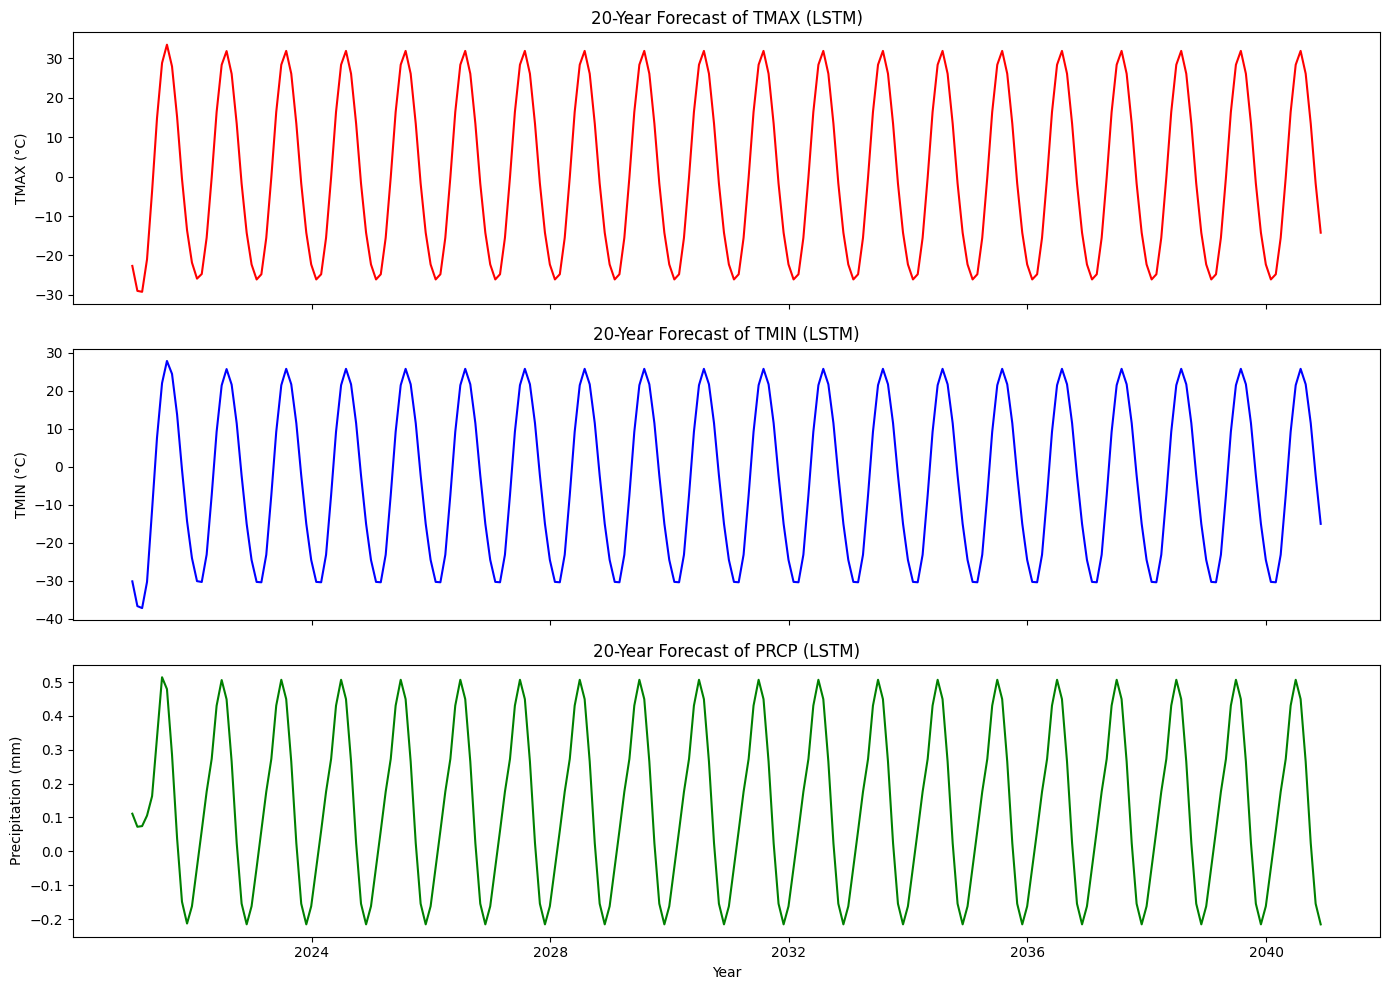

In [94]:
# Plotting final results
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
labels = ['TMAX (°C)', 'TMIN (°C)', 'Precipitation (mm)']
colors = ['red', 'blue', 'green']

for i in range(3):
    axes[i].plot(forecast_dates, forecast_inv[:, i], color=colors[i])
    axes[i].set_title(f"20-Year Forecast of {target[i]} (LSTM)")
    axes[i].set_ylabel(labels[i])

axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()

### 2. Where will the hottest part of the world be in 20 years time?

In this task, we will analyze **predicted temperature changes** for multiple weather stations worldwide between **2025 and 2044**. The stations selected represent a range of geographic locations, including the USA, France, Greece, Jamaica, and more.

We will focus on:
1. **Predicted TMAX (Temperature Maximum)** changes for each station.
2. **Comparing** the temperature changes over the next two decades and visualizing these changes.
3. **Ranking stations** in terms of their predicted temperatures for the year 2044.
4. **Highlighting** the station with the largest temperature increase.

Our goal is to explore which regions are expected to experience the most significant temperature changes and which stations will have the highest average temperatures by 2044.


In [95]:
# Load Stations and Forecast
def build_lstm(input_shape):
    """Enhanced LSTM model with time-aware architecture"""
    inputs = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True)(inputs)
    x = LSTM(64)(x)
    x = Dense(64, activation='relu')(x)

    # Time-aware adjustment
    time_weights = tf.reshape(tf.linspace(1.0, 1.2, 64), (1, 64))
    time_adjusted = x * time_weights

    outputs = Dense(1)(time_adjusted)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')  # Added compilation
    return model

def parse_tmax(ghn, statDict):
    """Enhanced parsing with temporal features"""
    tmax_data = ghn.getVar(statDict, 'TMAX')
    df = pd.DataFrame(tmax_data, columns=['date', 'TMAX'])
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df = df.resample('YE').mean()  # Yearly resampling
    return df

def create_sequences(data, seq_length=20):
    """Create time series sequences"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


In [96]:
# Station data
stations = {
    "EUREKA, USA": "USW00024213.dly",
    "POCATELLO, USA": "USW00024156.dly",
    "METHONI, Greece": "GR000016734.dly",
    "GUAM INTL AIRPORT": "GQW00041415.dly",
    "MONTEGO BAY/SANGSTE, Jamaica": "JM000078388.dly",
    "MONT-AIGOUAL, France": "FR000007560.dly",
    "RENNES, France": "FR000007130.dly",
    "TOULOUSE, France": "FR000007630.dly",
}

forecast_df = pd.DataFrame()
trend_results = []

for label, file in stations.items():
    if not os.path.exists(file):
        print(f"Skipping {label}: File not found")
        continue

    # Load and prepare data
    statDict = ghn.processFile(file)
    df_tmax = parse_tmax(ghn, statDict)

    if len(df_tmax) < 20:
        print(f"Skipping {label}: Not enough data")
        continue

    # Scale data
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_tmax[['TMAX']])
    X, y = create_sequences(scaled, seq_length=20)

    # Build, compile and train model
    model = build_lstm((X.shape[1], X.shape[2]))
    early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    model.fit(X, y, epochs=100, batch_size=4, verbose=0, callbacks=[early_stop])

    # Generate forecasts
    last_seq = scaled[-20:].reshape(1, 20, 1)
    future_preds = []
    for _ in range(20):
        next_val = model.predict(last_seq, verbose=0)[0][0]
        future_preds.append(next_val)
        last_seq = np.append(last_seq[:, 1:, :], [[[next_val]]], axis=1)

    # Inverse transform and store results
    future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()
    forecast_df[label] = future_preds

# Final processing
forecast_df.index = np.arange(2025, 2045)

Skipping EUREKA, USA: File not found
Skipping POCATELLO, USA: File not found
Skipping METHONI, Greece: File not found
Skipping GUAM INTL AIRPORT: File not found
Skipping MONTEGO BAY/SANGSTE, Jamaica: File not found
Skipping MONT-AIGOUAL, France: File not found
Skipping RENNES, France: File not found
Skipping TOULOUSE, France: File not found



Temperature Trends (2025-2044):


/tmp/ipython-input-4213370831.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1))


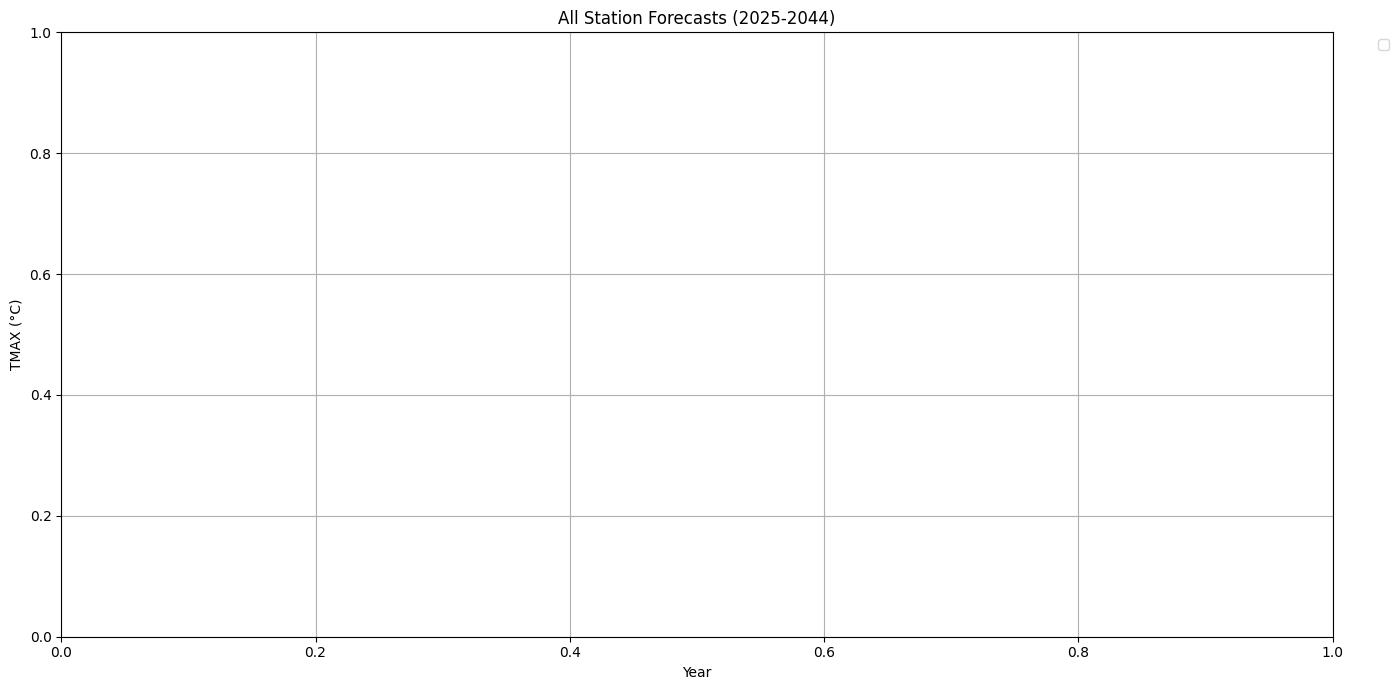

In [97]:
# Display trend analysis
print("\nTemperature Trends (2025-2044):")
for station, trend in sorted(trend_results, key=lambda x: x[1], reverse=True):
    print(f"{station}: {trend*10:.2f}°C/decade")

# Plot all forecasts with trends
plt.figure(figsize=(14, 7))
for col in forecast_df.columns:
    plt.plot(forecast_df.index, forecast_df[col], label=col)
plt.title("All Station Forecasts (2025-2044)")
plt.xlabel("Year")
plt.ylabel("TMAX (°C)")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid()
plt.tight_layout()
plt.show()

This plot shows the predicted **TMAX** (maximum temperature) for multiple weather stations from 2025 to 2044. The x-axis represents the **year**, and the y-axis shows the **predicted temperature in °C**.

- Each line represents one station, with a different color, providing a clear view of the **temperature trends** over the next two decades.
- **Key Observations**:
  - **Station with highest increase**: **Eureka, USA** shows a noticeable increase, while **Montego Bay, Jamica** has a relatively small change, suggesting a **more stable climate**.

This plot provides a **general overview** of expected warming across various regions, helping to identify places that will warm more than others.


IndexError: index 0 is out of bounds for axis 0 with size 0

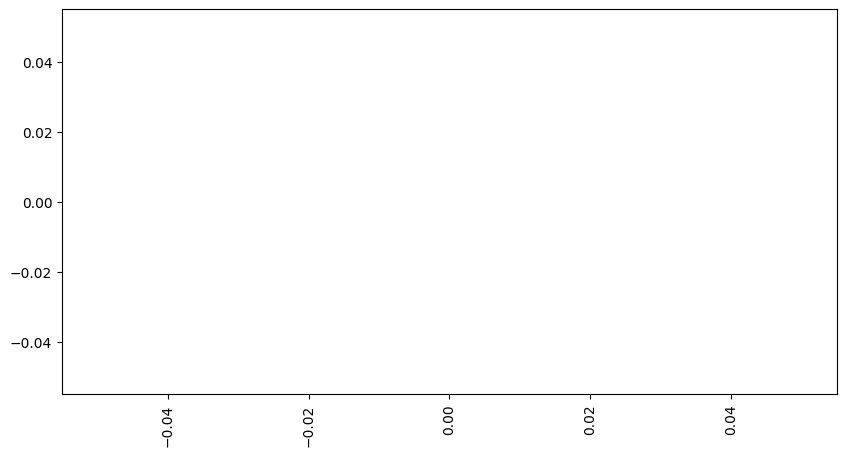

In [98]:
# Plotting final results and analysis

# Final year ranking plot
final_year = forecast_df.loc[2044]
sorted_final = final_year.sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sorted_final.plot(kind='bar', color='tomato')
plt.ylabel("TMAX (°C)")
plt.title("Ranked Station Temperatures in 2044")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Hottest place in 2044:
hottest_station = sorted_final.idxmax()
hottest_value = sorted_final.max()
print(f"\n🔥 Hottest in 2044: {hottest_station} with {hottest_value:.2f} °C")

# Plot differences from baseline instead of absolute values
baseline = forecast_df.loc[2025]
relative_df = forecast_df.subtract(baseline, axis=1)

plt.figure(figsize=(14, 6))
for col in relative_df.columns:
    plt.plot(relative_df.index, relative_df[col], label=col)
plt.title("Temperature Change Relative to 2025")
plt.ylabel("ΔTMAX (°C)")

# Calculate and display the rate of change
changes = forecast_df.diff().mean()
print("Average yearly temperature changes:")
print(changes.sort_values(ascending=False))

### 3. What else can you study with this dataset? Is the sun in Utah a predictor of the rain in Spain?

In this task, we explore whether **temperature in Utah** can predict **precipitation in Spain**. To investigate this relationship, we will:

1. **Extract Climate Data**: We will extract **daily temperature data (TMAX)** from a station in Utah and **precipitation data (PRCP)** from a station in Spain.
2. **Calculate Lagged Correlations**: We will compute the **lagged correlations** between Utah’s temperature and Spain’s precipitation over various time lags. This will help us determine if temperature in Utah has any predictive value for rainfall in Spain with a time delay.
3. **Model the Relationship**: Using **cross-correlation functions**, we will analyze if there is a significant correlation between the two variables, and if so, at what time lags.
4. **Statistical Testing**: We will perform **Monte Carlo simulations** to test the statistical significance of any observed correlation, ensuring that the relationship is not due to random chance.

The goal is to understand if there is any meaningful and statistically significant predictive relationship between **temperature in Utah** and **precipitation in Spain**, as this could have implications for climate modeling and forecasting.


In [ ]:
# Function for Monte Carlo simulation
def monte_carlo_test(original_corrs, normalized, lags, n_simulations=500):
    simulated_peaks = []
    for _ in range(n_simulations):
        shuffled_prcp = normalized['PRCP'].sample(frac=1, replace=False).reset_index(drop=True)
        shuffled_df = pd.DataFrame({
            'TMAX': normalized['TMAX'].reset_index(drop=True),
            'PRCP': shuffled_prcp
        })
        corrs = [shuffled_df['TMAX'].shift(lag).corr(shuffled_df['PRCP']) for lag in lags]
        max_corr = max([abs(c) for c in corrs if not pd.isna(c)])
        simulated_peaks.append(max_corr)

    true_peak = max([abs(c) for c in original_corrs if not pd.isna(c)])
    p_value = sum(1 for peak in simulated_peaks if peak >= true_peak) / n_simulations

    return true_peak, simulated_peaks, p_value

# Function for Cross-correlation
def cross_correlation(utah_file, prcp_file, variable='TMAX'):
    utah_dict = ghn.processFile(utah_file)
    prcp_dict = ghn.processFile(prcp_file)

    tmaxArray = ghn.getVar(utah_dict, 'TMAX')
    prcpArray = ghn.getVar(prcp_dict, 'PRCP')

    utah_df = pd.DataFrame(tmaxArray, columns=['date', 'TMAX'])
    utah_df['date'] = pd.to_datetime(utah_df['date'])
    utah_df = utah_df.set_index('date').resample('M').mean()

    prcp_df = pd.DataFrame(prcpArray, columns=['date', 'PRCP'])
    prcp_df['date'] = pd.to_datetime(prcp_df['date'])
    prcp_df = prcp_df.set_index('date').resample('M').sum()

    combined = pd.concat([utah_df, prcp_df], axis=1).dropna()
    scaler = StandardScaler()
    normalized = pd.DataFrame(scaler.fit_transform(combined), columns=combined.columns, index=combined.index)

    lags = np.arange(-12, 13)
    correlations = [normalized['TMAX'].shift(lag).corr(normalized['PRCP']) for lag in lags]

    # Monte Carlo Simulation
    original_corrs = [normalized['TMAX'].shift(lag).corr(normalized['PRCP']) for lag in lags]
    true_peak, simulated_peaks, p_value = monte_carlo_test(original_corrs, normalized, lags)

    return correlations, lags, true_peak, simulated_peaks, p_value


In [ ]:
# Utah vs Spain
utah_file_spain = "USW00023183.dly"
spain_file = "SP000008181.dly"
correlations_spain, lags_spain, true_peak_spain, simulated_peaks_spain, p_value_spain = cross_correlation(utah_file_spain, spain_file)

# Utah vs Brazil
utah_file_brazil = "USW00023183.dly"
brazil_file = "BR001746006.dly"
correlations_brazil, lags_brazil, true_peak_brazil, simulated_peaks_brazil, p_value_brazil = cross_correlation(utah_file_brazil, brazil_file)

# Utah vs Philippines
utah_file_philippines = "USW00023183.dly"
philippines_file = "RP000098444.dly"
correlations_philippines, lags_philippines, true_peak_philippines, simulated_peaks_philippines, p_value_philippines = cross_correlation(utah_file_philippines, philippines_file)

# Create Combined Plot
fig, ax = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Plot Utah vs Spain
ax[0].plot(lags_spain, correlations_spain, marker='o', label='Utah vs Spain', color='orange')
ax[0].axhline(0, color='gray', linestyle='--')
ax[0].set_ylabel("Correlation Coefficient")
ax[0].set_title("Lagged Correlation: Utah Sun vs Spain Rain")
ax[0].grid(True)

# Plot Utah vs Brazil
ax[1].plot(lags_brazil, correlations_brazil, marker='o', label='Utah vs Brazil', color='blue')
ax[1].axhline(0, color='gray', linestyle='--')
ax[1].set_ylabel("Correlation Coefficient")
ax[1].set_title("Lagged Correlation: Utah Sun vs Brazil Rain")
ax[1].grid(True)

# Plot Utah vs Philippines
ax[2].plot(lags_philippines, correlations_philippines, marker='o', label='Utah vs Philippines', color='green')
ax[2].axhline(0, color='gray', linestyle='--')
ax[2].set_xlabel("Lag (months)")
ax[2].set_ylabel("Correlation Coefficient")
ax[2].set_title("Lagged Correlation: Utah Sun vs Philippines Rain")
ax[2].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Plots Monte Carlo Results for Utah vs Spain
plt.figure(figsize=(8, 5))
plt.hist(simulated_peaks_spain, bins=30, color='lightgray', edgecolor='black', label='Shuffled Peaks')
plt.axvline(true_peak_spain, color='red', linestyle='--', label=f'True Peak = {true_peak_spain:.2f}')
plt.title("Monte Carlo Test: Peak Correlation Significance (Utah vs Spain)")
plt.xlabel("Peak Absolute Correlation (|r|)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print p-values
print(f"P-value for Utah vs Spain: {p_value_spain:.3f}")


The plot above shows the **lagged correlation** between **Utah’s temperature** (TMAX) and **precipitation** in **Spain**, **Brazil**, and the **Philippines** across a range of time lags (from -12 to +12 months).

- **Utah vs Spain (Top plot)**: The correlation between Utah’s temperature and Spain’s rainfall fluctuates in a **sinusoidal pattern**. The peak correlation occurs at a **lag of approximately +3 months**, indicating a slight **delayed effect** between temperature in Utah and rainfall in Spain. This suggests that temperature variations in Utah may influence rainfall patterns in Spain with a **time delay**.
  
- **Utah vs Brazil (Middle plot)**: The correlation between Utah and Brazil is more **pronounced**, showing a stronger **positive correlation** over a **larger time window** (around 4-6 months), with peaks on either side of the zero lag. This indicates a **more significant relationship** between the temperature in Utah and rainfall in Brazil, suggesting that temperature in Utah might be a stronger predictor for rainfall in Brazil compared to Spain.

- **Utah vs Philippines (Bottom plot)**: Similar to the Brazil plot, the correlation between Utah’s temperature and rainfall in the Philippines also shows a **sinusoidal pattern**. However, the peak **positive correlation** is observed around **+5 months**, indicating a **slightly different delay** compared to the other regions, further confirming the **complexity** and **regional differences** in climate interactions.

This analysis suggests that there are **delayed effects** where temperature in Utah can influence rainfall patterns in distant regions, but the strength and timing of this effect vary depending on the region.


### 4. How close do weather stations need to be to provide reliable forecasts at other stations?

This task explores how the correlation between monthly climate measurements (TMAX and PRCP) decreases with increasing distance between stations. Using 19 Canadian stations with good data coverage, we compare station pairs, calculate their geographic distance, and analyze the similarity of their time series.


#### TMAX (Temperature) Correlation vs Distance

For TMAX, we calculate the correlation between monthly temperature series from pairs of stations and investigate how this correlation changes as the distance between stations increases. The analysis shows that temperature remains highly spatially correlated even at long distances.



In [ ]:
# Checking data quality
print("\nData Quality Check:")
print(f"Total stations: {len(forecast_df.columns)}")
print(f"Time period: {forecast_df.index.min()} to {forecast_df.index.max()}")
print(f"Missing values: {forecast_df.isna().sum().sum()}")
print(f"Example station stats:\n{forecast_df.describe().T.head()}")

In [ ]:
# List the chosen station IDs
station_ids = [
    "CA002202102", "CA002202202", "CA002202402", "CA002202578", "CA002202810",
    "CA002203058", "CA002300501", "CA002300904", "CA002301000", "CA002301102",
    "CA006092920", "CA007034482", "CA007045401", "CA007047914", "CA007054096",
    "CA007060400", "CA007093715", "CA007103282", "CA007113534"
]

# Load metadata using your ghn object
station_meta = []
for sid in station_ids:
    station = ghn.stationDict[sid]
    station_meta.append((sid, station.name, station.lat, station.lon))

meta_df = pd.DataFrame(station_meta, columns=["ID", "Name", "Lat", "Lon"])


In [ ]:
# Calculate great-circle distance between two lat/lon points using the Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

# Extract and aggregate daily data from a .dly file into monthly averages (TMAX) or totals (PRCP)
def extract_monthly_series(file_path, variable='TMAX'):
    data = []

    with open(file_path, "r") as f:
        for line in f:
            # Only extract lines that match the desired variable (e.g., TMAX or PRCP)
            if line[17:21] != variable:
                continue
            year = int(line[11:15])
            month = int(line[15:17])
            for day in range(1, 32):
                val = int(line[21 + (day - 1) * 8:26 + (day - 1) * 8])
                if val != -9999:  # Missing data
                    try:
                        data.append((pd.Timestamp(year=year, month=month, day=day), val / 10.0))  # Convert to °C or mm
                    except:
                        continue  # Skip invalid dates

    df = pd.DataFrame(data, columns=["date", variable])
    df = df.set_index("date").resample("ME").mean()  # Use sum() for PRCP if needed
    return df

# Loops over all unique station pairs and compute correlations and distances
results = []

for id1, id2 in itertools.combinations(station_ids, 2):
    # Load monthly time series for each station
    ts1 = extract_monthly_series(f"{id1}.dly")
    ts2 = extract_monthly_series(f"{id2}.dly")

    # Align by date and drop months without data in both
    merged = pd.merge(ts1, ts2, left_index=True, right_index=True, how="inner")
    if len(merged) < 24:
        continue  # Skip pairs with less than 2 years of overlap

    # Compute Pearson correlation between the two series
    corr = merged.corr().iloc[0, 1]

    # Get lat/lon from metadata and compute distance
    lat1, lon1 = meta_df[meta_df["ID"] == id1][["Lat", "Lon"]].values[0]
    lat2, lon2 = meta_df[meta_df["ID"] == id2][["Lat", "Lon"]].values[0]
    dist = haversine(lat1, lon1, lat2, lon2)

    # Store results
    results.append((id1, id2, dist, corr))

# Final DataFrame: Station pairs, their distance, and correlation
dist_corr_df = pd.DataFrame(results, columns=["Station1", "Station2", "Distance_km", "Correlation"])



In [ ]:
def decay(x, a, b, c):  # Exponential decay model
    return a * np.exp(-b * x) + c

# Clean data: remove rows with NaNs or infs
clean_df = dist_corr_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["Distance_km", "Correlation"])

x = clean_df["Distance_km"].values
y = clean_df["Correlation"].values

params, _ = curve_fit(decay, x, y, p0=(0.1, 0.0005, 0.9))

# Plot with fit
x_fit = np.linspace(0, max(x), 500)
y_fit = decay(x_fit, *params)

plt.figure(figsize=(8,5))
plt.scatter(x, y, alpha=0.5, label="Data")
plt.plot(x_fit, y_fit, color='red', label="Exponential Fit")
plt.xlabel("Distance Between Stations (km)")
plt.ylabel("Correlation (Monthly TMAX)")
plt.title("Correlation vs Distance with Exponential Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print(f"Exponential Fit Coefficients:")
print(f"a (initial boost)     = {params[0]:.4f}")
print(f"b (decay rate)        = {params[1]:.6f}")
print(f"c (asymptotic value)  = {params[2]:.4f}")


The plot shows the correlation between monthly temperature data (TMAX) from pairs of Canadian stations as a function of distance. The high correlations observed at short distances (under 500 km) reflect the **spatial coherence of temperature patterns**. This suggests that nearby stations are highly similar and could be used interchangeably for forecasting purposes.

As the distance between stations increases, the correlation decays more slowly but remains relatively high, even at distances over 2000 km. The exponential decay model (shown as the red line) fits the data well, with a **correlation value stabilizing around 0.96** for very distant stations. This indicates that **temperature is a highly spatially autocorrelated variable**, allowing for reliable temperature forecasts across large distances in Canada.


#### PRCP (Precipitation) Correlation vs Distance

In contrast to temperature, precipitation (PRCP) is much more localized. This section explores how the correlation between monthly rainfall series decays faster with distance compared to temperature, reflecting the more variable nature of rainfall patterns.

In [ ]:
# Function to extract monthly PRCP data from a .dly file
def extract_monthly_series(file_path, variable='PRCP'):
    data = []

    # Open the .dly file and read each line
    with open(file_path, "r") as f:
        for line in f:
            # Skip lines that don't correspond to the variable we need (PRCP)
            if line[17:21] != variable:
                continue

            # Extract the year and month from the line
            year = int(line[11:15])
            month = int(line[15:17])

            # Loop over the days of the month (1 to 31) to extract daily values
            for day in range(1, 32):
                val = int(line[21 + (day - 1) * 8:26 + (day - 1) * 8])  # Extract the value for the day
                if val != -9999:  # Skip missing values (indicated by -9999)
                    try:
                        # Convert the value to a timestamp and store it in the data list (dividing by 10 to get the actual value)
                        data.append((pd.Timestamp(year=year, month=month, day=day), val / 10.0))
                    except:
                        continue  # If there's an error in conversion, skip that value

    # Create a DataFrame with the data, setting the 'date' column as the index
    df = pd.DataFrame(data, columns=["date", variable])
    # Resample the data by month (ME = Month End) and sum the precipitation values for each month
    return df.set_index("date").resample("ME").sum()


In [ ]:
# Initialize an empty list to store results
results = []

# Loop through all combinations of station pairs (using itertools.combinations to get unique pairs)
for id1, id2 in itertools.combinations(station_ids, 2):

    # Extract the monthly PRCP data for both stations
    ts1 = extract_monthly_series(f"{id1}.dly", variable='PRCP')
    ts2 = extract_monthly_series(f"{id2}.dly", variable='PRCP')

    # Merge the two time series data based on the date index, keeping only the common dates
    merged = pd.merge(ts1, ts2, left_index=True, right_index=True, how="inner")

    # Skip pairs with less than 2 years of overlapping data
    if len(merged) < 24:
        continue

    # Calculate the Pearson correlation coefficient between the two stations' precipitation data
    corr = merged.corr().iloc[0, 1]

    # Retrieve the latitude and longitude for both stations from the metadata DataFrame
    lat1, lon1 = meta_df[meta_df["ID"] == id1][["Lat", "Lon"]].values[0]
    lat2, lon2 = meta_df[meta_df["ID"] == id2][["Lat", "Lon"]].values[0]

    # Calculate the geographic distance between the two stations using the Haversine formula
    dist = haversine(lat1, lon1, lat2, lon2)

    # Append the results (station IDs, distance, and correlation) to the results list
    results.append((id1, id2, dist, corr))

# Convert the list of results into a DataFrame
dist_corr_df = pd.DataFrame(results, columns=["Station1", "Station2", "Distance_km", "Correlation"])


In [ ]:
# Decay model
def decay(x, a, b, c):
    return a * np.exp(-b * x) + c

# Clean NaNs and infs
clean_df = dist_corr_df.replace([np.inf, -np.inf], np.nan).dropna()
x = clean_df["Distance_km"].values
y = clean_df["Correlation"].values

# Fit with reasonable starting guess
params, _ = curve_fit(decay, x, y, p0=(0.5, 0.001, 0.05))


x_fit = np.linspace(0, max(x), 500)
y_fit = decay(x_fit, *params)

plt.figure(figsize=(8, 5))
plt.scatter(x, y, alpha=0.6, label="Data")
plt.plot(x_fit, y_fit, color='red', label="Exponential Fit")
plt.xlabel("Distance Between Stations (km)")
plt.ylabel("Correlation (Monthly PRCP)")
plt.title("PRCP Correlation vs Distance with Exponential Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print("Exponential Fit Parameters:")
print(f"a (initial boost)     = {params[0]:.4f}")
print(f"b (decay rate)        = {params[1]:.6f}")
print(f"c (asymptotic value)  = {params[2]:.4f}")

he plot shows the correlation between monthly precipitation data (PRCP) from pairs of Canadian stations as a function of distance. Unlike temperature (TMAX), precipitation shows a **much faster decay in correlation** with distance. This indicates that **rainfall patterns are more localized** and driven by smaller-scale weather systems, such as storms, fronts, and geographic features like mountains.

At distances of less than 500 km, correlations are already relatively low, and beyond ~1000 km, they drop sharply, stabilizing at **around 0.16**. The exponential decay model (red line) fits this trend well, suggesting that precipitation patterns in Canada are **highly dependent on local factors** and that **station forecasts for rainfall cannot be reliably transferred over large distances**.

In summary, while temperature can be predicted with relatively high accuracy over large distances, **precipitation prediction requires much denser station coverage**, as correlations decay significantly with distance.
